# Projet P6 - Analysez les ventes d'une librairie avec R ou Python

*OPENCLASSROOMS - Parcours Data Analyst V2 - Adeline Le Ray - Novembre 2022*
<hr>

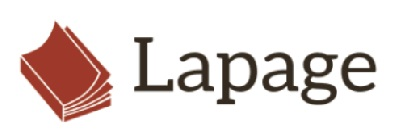

## <font color='blue'>Sommaire</font>

**[Partie 3 - Analyses des données : indicateurs des ventes](#partie3)**
* [1. Jointure des 3 data frames](#3_1)
* [2. Chiffre d'affaires](#3_2)
    * [a. Chiffre d'affaires annuel](#3_2_1)
    * [b. Chiffre d'affaires mensuel](#3_2_2)
    * [c. Chiffre d'affaires journalier](#3_2_3)
* [3. Ventes](#3_3)
    * [a. Ventes mensuelles](#3_3_1)
    * [b. Ventes par références produits : tops et flops](#3_3_2)
    * [c. Répartition des ventes par catégories](#3_3_3)
* [4. Profils clients](#3_4)      
    * [a. Création du df_client](#3_4_1)
    * [b. Identification des profils client](#3_4_2)
    * [c. Chiffre d'affaires par profils client](#3_4_3)
* [5. Analyses complémentaires](#3_5)
    * [a. Chiffres clés par période](#3_5_1)
    * [b. Informations sur les clients](#3_5_2)
    * [c. Habitudes d'achats des profils clients](#3_5_3)

###  Importation des librairies

In [1]:
# Importation des librairies pandas, numpy, pyplot de matplotlib, seaborn, plotly, datetime, scipy stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import datetime as dt

### Importation des fichiers de données

In [2]:
# Importation des dataframes issus des parties 1 & 2
df_customers=pd.read_csv('df_customers.csv',index_col=0)
df_products=pd.read_csv('df_products.csv',index_col=0)
df_transactions=pd.read_csv('df_transactions.csv',index_col=0)

In [3]:
#Conversion en format date et remplacement des erreurs par 'NaT'
df_transactions['date']=pd.to_datetime(df_transactions['date'],errors='coerce')

In [4]:
df_transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

## <font color='blue'>Partie 3 - Analyse des données : indicateurs des ventes<a class="anchor" id="partie3"></a></font>

La partie 3 présente les résultats des analyses  suivantes : 
- Chiffre d'affaires
    - Différents indicateurs et graphiques autour du chiffre d'affaires
    - Evolution dans le temps du chiffre d'affaires 
- Ventes
    - Tops et flops des références 
    - Répartition par catégorie
- Profils clients
    - Informations sur les profils de nos clients
    - Répartition du chiffre d'affaires entre les profils clients, via par exemple une courbe de Lorenz.
- Analyse complémentaire 
    - Chiffres clés par période d'activité
    - Informations sur les clients
    - Habitudes d'achats des profils clients

### 1. Jointure des 3 data frames<a class="anchor" id="3_1"></a>

#### a. Etude des clés primaires pour les jointures<a class="anchor" id="3_1_1"></a>

##### Nombres de valeurs de chaque clé

In [5]:
print("Il y a",df_products['id_prod'].unique().shape[0],"identifiants 'id_prod' uniques sur",df_products['id_prod'].count())

Il y a 3286 identifiants 'id_prod' uniques sur 3286


In [6]:
print("Il y a",df_transactions['id_prod'].unique().shape[0],"identifiants 'id_prod' uniques dans le df_transactions")

Il y a 3266 identifiants 'id_prod' uniques dans le df_transactions


In [7]:
print("Il y a",df_customers['client_id'].unique().shape[0],"identifiants 'client_id' uniques sur",
      df_customers['client_id'].count())

Il y a 8623 identifiants 'client_id' uniques sur 8623


In [8]:
print("Il y a",df_transactions['client_id'].unique().shape[0],"identifiants 'client_id' uniques dans le df_transactions")

Il y a 8600 identifiants 'client_id' uniques dans le df_transactions


##### Correspondances des clés dans les df à joindre : identifications des éventuelles erreurs

Avant de procéder aux jointures, nous vérifions les correspondances clés primaires / clés étrangères. 

In [9]:
# Création de la liste des client_id du df_customers
client_id=df_customers.groupby(['client_id']).count().index
df_trans_client=df_transactions.groupby(['client_id']).count().reset_index()

# Comparaison entre la liste des clients du df_customers et les clients présents dans le df_transactions
print('Il y a ',df_trans_client.loc[~df_trans_client['client_id'].isin(client_id),:].shape[0],
      "clients du df 'transactions' qui ne sont pas présents dans le df 'customers'")

Il y a  0 clients du df 'transactions' qui ne sont pas présents dans le df 'customers'


In [10]:
# Création de la liste des id_prod du df_products
id_prod=df_products.groupby(['id_prod']).count().index
df_trans_prod=df_transactions.groupby(['id_prod']).count().reset_index()

# Comparaison entre la liste des produits du df_products et les produits présents dans le df_transactions
print('Il y a ',df_trans_prod.loc[~df_trans_prod['id_prod'].isin(id_prod),:].shape[0],
      "produits du df 'transactions' qui n'est pas présent dans le df 'products'")

Il y a  1 produits du df 'transactions' qui n'est pas présent dans le df 'products'


In [11]:
# Identification du produit manquant dans le df_products
error_prod=df_trans_prod.loc[~df_trans_prod['id_prod'].isin(id_prod),'id_prod'].iloc[0]

#Affichage des transactions concernées 
df_transactions.loc[df_transactions['id_prod']==error_prod,:]

id_prod                       date session_id client_id
2633    0_2245 2022-09-23 07:22:38.636773   s_272266    c_4746
10106   0_2245 2022-07-23 09:24:14.133889   s_242482    c_6713
11727   0_2245 2022-12-03 03:26:35.696673   s_306338    c_5108
15675   0_2245 2021-08-16 11:33:25.481411    s_76493    c_1391
16377   0_2245 2022-07-16 05:53:01.627491   s_239078    c_7954
...        ...                        ...        ...       ...
669730  0_2245 2021-08-25 09:06:03.504061    s_80395     c_131
670682  0_2245 2022-03-06 19:59:19.462288   s_175311    c_4167
671286  0_2245 2022-05-16 11:35:20.319501   s_209381    c_4453
675679  0_2245 2022-02-11 09:05:43.952857   s_163405    c_1098
677996  0_2245 2021-12-14 22:34:54.589921   s_134446    c_4854

[221 rows x 4 columns]

=> Il y a 221 transactions pour le livre dont le prix ne figure pas dans le df_products.

<font color='red'>**Ce point est à étudier pour comprendre pourquoi le prix du livre '0_2245' ne figure pas dans le listing produits mais que des transactions ont pu être effectuées en ligne.**</font>

#### b. Première jointure : df_transactions et df_products<a class="anchor" id="3_1_2"></a>

Première jointure 
- data frames : 'df_transactions' et 'df_products', le df 'transactions' contient le plus d'informations.
- type de jointure externe, afin de conserver les livres qui n'ont pas été vendus = les flops
- clé : 'id_prod'

In [12]:
# Jointure des df_transactions et df_products
df_1=pd.merge(df_transactions,df_products,on='id_prod',how='outer',indicator=True)

# dimension du df après jointure
print("")
print("Les dimensions du data frame obtenu après jointure des df transactions et products sont "+str(df_1.shape))


Les dimensions du data frame obtenu après jointure des df transactions et products sont (679353, 7)


In [13]:
# aperçu du df après jointure
df_1.head()

id_prod                       date session_id client_id  price  categ _merge
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   both
1  0_1518 2021-09-26 12:37:29.780414    s_95811    c_6197   4.18    0.0   both
2  0_1518 2021-05-06 17:14:43.117440    s_30782     c_682   4.18    0.0   both
3  0_1518 2022-03-16 18:57:10.420103   s_180057    c_5932   4.18    0.0   both
4  0_1518 2022-11-12 18:58:10.574853   s_296584    c_7217   4.18    0.0   both

##### Analyse du résultat de la première jointure

In [14]:
#Filtrage sur les valeurs de la colonne '_merge' qui sont différentes de 'both'
print("Il y a ",df_1.loc[df_1['_merge']!='both',:].shape[0]," lignes qui ne sont pas dans les 2 df.")

Il y a  242  lignes qui ne sont pas dans les 2 df.


In [15]:
#Filtrage sur les valeurs de la colonne '_merge'= 'right_only'
df_right=df_1.loc[df_1['_merge']=='right_only',:]

print("Pour les produits uniquement présents dans le df_products :")
print("- nombre de id_prod :",df_right.shape[0])

Pour les produits uniquement présents dans le df_products :
- nombre de id_prod : 21


In [16]:
#Filtrage sur les valeurs de la colonne '_merge'= 'left_only'
df_left=df_1.loc[df_1['_merge']=='left_only',:]

print("Poour les produits uniquement présents dans le df_transactions :")
print("- nombre de transactions :",df_left.shape[0])
print("- id_prod :",df_left.groupby('id_prod').sum().index.array[0])

Poour les produits uniquement présents dans le df_transactions :
- nombre de transactions : 221
- id_prod : 0_2245


Cela est cohérent avec l'obervation faite dans le [paragraphe précédent](#3_1_1). Pour conserver les transactions liées au livre id_prod=0_2245 pour le calcul du chiffre d'affaires, il faut imputer un prix de vente à ce produit.

##### Imputation d'un prix et d'une catégorie aux valeurs manquantes du livre référence '0_2245'

Pour le livre 0_2245 :
- la catégorie est '0' (premier chiffre de l'id_prod) 
- la médiane de la catégorie '0' peut être choisie comme prix de ventes.

*La médiane  a une bien meilleure robustesse que la moyenne en présence de valeurs extrêmes*

In [17]:
# Imputation categ = 0 pour id_prod=0_2245
df_1.loc[df_1['id_prod']=='0_2245','categ']=0

In [18]:
# Calcul de la médiane de la catégorie 0
med_categ0=df_products.loc[df_products['categ']==0,'price'].median()

# Imputation price = mediane categ 0 pour id_prod=0_2245
df_1.loc[df_1['id_prod']=='0_2245','price']=med_categ0

#### c. Deuxième jointure : df_1 et df_customers<a class="anchor" id="3_1_2"></a>

Deuxième jointure 
- data frames : 'df_t1' et 'df_customers', le df_1 contient le plus d'informations.
- type de jointure externe, afin de conserver les clients qui n
- clé : 'client_id'

In [19]:
# Suppression de la colonne _merge
df_1.pop('_merge')

# Jointure des df_transactions et df_products
df_2=pd.merge(df_1,df_customers,on='client_id',how='outer',indicator=True)

# dimension du df après jointure
print("")
print("Les dimensions du data frame obtenu après jointure des df_1 et df_customers sont "+str(df_2.shape))


Les dimensions du data frame obtenu après jointure des df_1 et df_customers sont (679376, 10)


In [20]:
# aperçu du df après jointure
df_2.head()

id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   
2  0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   f   
3  0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   f   
4  0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   f   

    birth   age _merge  
0  1986.0  37.0   both  
1  1986.0  37.0   both  
2  1986.0  37.0   both  
3  1986.0  37.0   both  
4  1986.0  37.0   both

##### Analyse du résultat de la deuxième jointure

In [21]:
#Filtrage sur les valeurs de la colonne '_merge' qui sont différentes de 'both'
print("Il y a",df_2.loc[df_2['_merge']!='both',:].shape[0]," lignes qui ne sont pas dans les 2 df.")

Il y a 44  lignes qui ne sont pas dans les 2 df.


In [22]:
#Filtrage sur les valeurs de la colonne '_merge'= 'right_only'
df_right=df_2.loc[df_2['_merge']=='right_only',:]

print("Nombre de clients uniquement présents dans le df_customers:\n",df_right.shape[0])


Nombre de clients uniquement présents dans le df_customers:
 23


=> 23 clients n'ont pas effectué de transactions sur la boutique en ligne.

In [23]:
#Filtrage sur les valeurs de la colonne '_merge'= 'left_only'
df_left=df_2.loc[df_2['_merge']=='left_only',:]

print("Pour les clients uniquement présents dans le df_1:")
print("- nombre de transactions/livres :",df_left.shape[0])
print("- nombre de client_id :",df_left.groupby('client_id').sum().shape[0])

Pour les clients uniquement présents dans le df_1:
- nombre de transactions/livres : 21
- nombre de client_id : 0


=> Il s'agit des 21 livres pour lesquels il n'y a pas eu de transactions dans la boutique en ligne. Ce résultat est cohérent avec l'analyse réalisée sur la première jointure.

In [24]:
# Suppression de la colonne _merge
df_2.pop('_merge')

# Renommer le data frame
df_final=df_2

### 2. Chiffre d'affaires<a class="anchor" id="3_2"></a>

In [25]:
df_final['année']=df_final['date'].dt.strftime('%Y')
df_final['mois']=df_final['date'].dt.strftime('%Y-%m')
df_final['jour']=df_final['date'].dt.strftime('%Y-%m-%d')

#### a. Chiffre d'affaires annuel<a class="anchor" id="3_2_1"></a>

In [26]:
print("Le chiffre d'affaires global pour les 2 années d'activités est de",round(df_final.price.sum()/1e6,1),"millions d'euros.")

Le chiffre d'affaires global pour les 2 années d'activités est de 11.9 millions d'euros.


#### b. Chiffre d'affaires mensuel<a class="anchor" id="3_2_2"></a>

##### Visualisation du chiffre d'affaires<a class="anchor" id="3_2_2_1"></a>

In [27]:
# Aggrégation par mois pour obtenir le chiffre d'affaires mensuel
ca_mensuel = df_final.groupby(df_final['mois'])['price'].sum().reset_index().rename(columns={'price':'CA mensuel'})

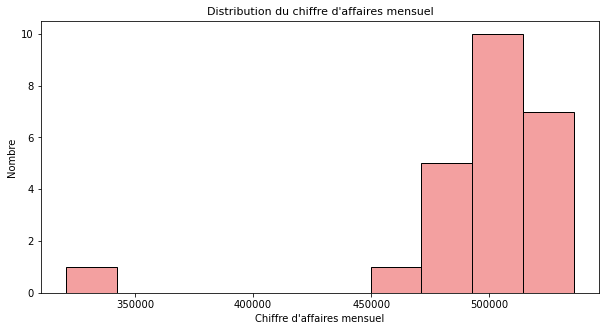

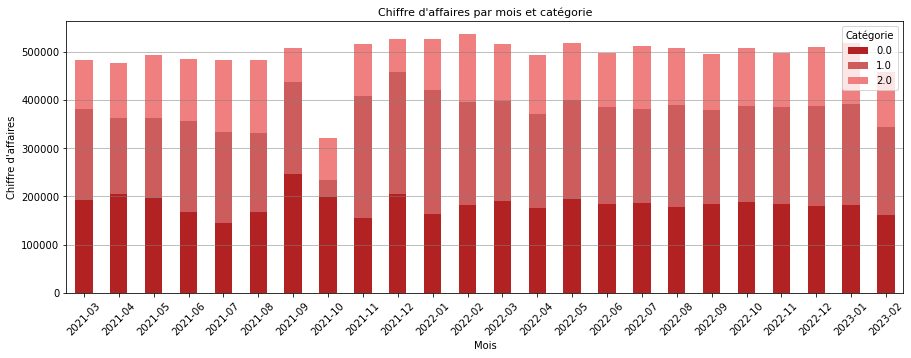

In [28]:
# Distrisbution du chiffre d'affaires mensuel
plt.figure(figsize=(10,5))
sns.histplot(data=ca_mensuel,x='CA mensuel',color='lightcoral')
plt.xlabel("Chiffre d'affaires mensuel")
plt.ylabel("Nombre")
plt.title("Distribution du chiffre d'affaires mensuel",fontsize=11)
plt.savefig('Distribution_CA.png')
plt.show()

# Représentation du CA mensuel de chaque catégorie de produit
df_final.pivot_table(index='mois', columns='categ',values='price', aggfunc='sum')\
         .plot.bar(stacked=True,color=['firebrick', "indianred", "lightcoral"],rot=45, figsize=(15,5))
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Chiffre d'affaires par mois et catégorie",fontsize=11)
plt.savefig('CA_mensuel.png')
plt.show()

Nous observons que le chiffre d'affaires du mois d'octobre 2021 est bien moins élevé que les autres mois sur la période de 2 ans.
Le chiffre d'affaires de la catégorie 1 est bien plus faible en octobre 2021.

**=> Il semble y avoir une anomalie sur les produits de catégorie 1 pour le mois d'octobre 2021 : rupture de stocks ou ventes non enregistrées?**

In [29]:
# Tableau croisé pour avoir les ventes par catégories et par jour sur octobre 2021https://www.r-graph-gallery.com/barplot
df_oct21 = df_final[(df_final.mois=='2021-10')]\
                    .pivot_table(index='jour',columns='categ',values='price',aggfunc='count').reset_index()              
df_oct21.columns=['jour','0.0','1.0','2.0']

Zoom sur octobre 2021 - Chiffre d'affaires par catégorie


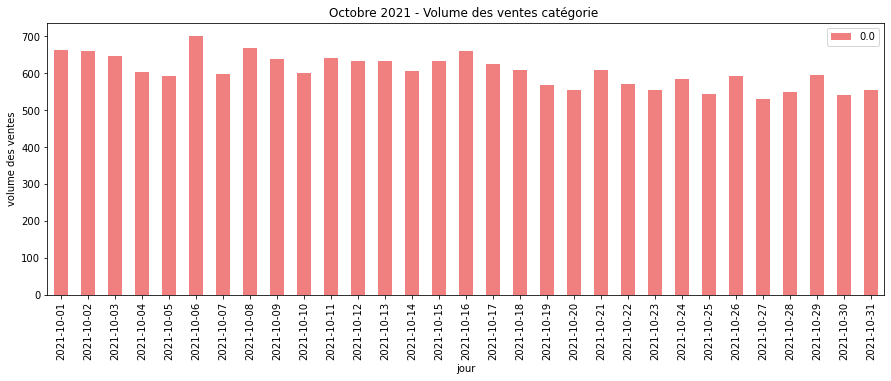

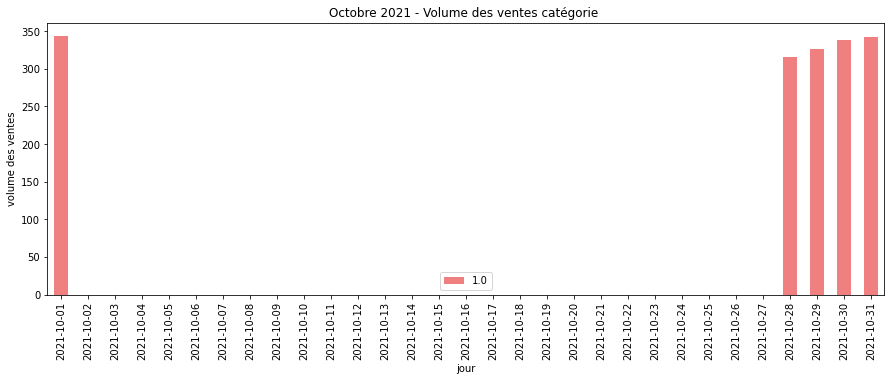

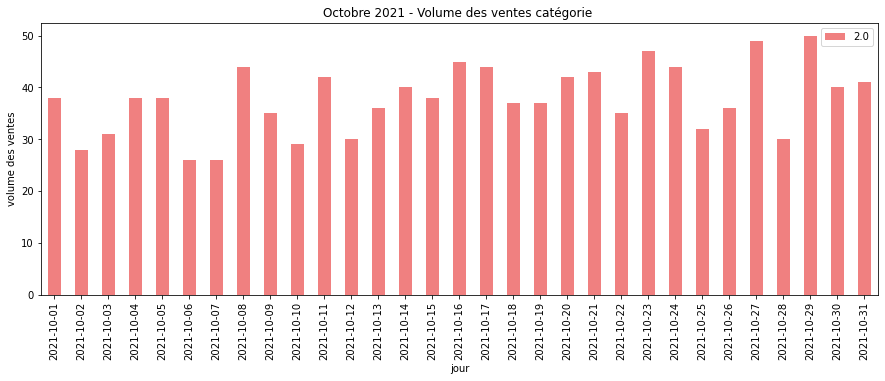

In [30]:
# Observations des indicateurs statistiques et graphiques pour chaque catégorie
print("Zoom sur octobre 2021 - Chiffre d'affaires par catégorie")

for cat in ('0.0','1.0','2.0'):
    df_oct21.plot.bar(x='jour',y=cat,color='lightcoral',figsize=(15,5))
    plt.xlabel('jour')
    plt.ylabel("volume des ventes")
    plt.title("Octobre 2021 - Volume des ventes catégorie ")
    plt.savefig(str(cat)+'Ca_oct2021.png')
    plt.show()

Pour la catégorie 1, il n'y a eu aucune vente enregistrée entre le 2 octobre et le 27 octobre 2021.
Pour l'analyse, le mois d'octobre ne sera pas considéré pour ne pas fausser les résultats de tendance.

###### Nettoyage : Tri sur les transactions hors mois d'octobre 2021

In [31]:
# tri des transactions : hors octobre 2021
df_final_ok=df_final.loc[df_final['mois']!='2021-10',:]
df_final_ok

id_prod                       date session_id client_id  price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   
1       0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   
2       0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   
3       0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   
4       0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   
...        ...                        ...        ...       ...    ...    ...   
679371     NaN                        NaT        NaN    c_7584    NaN    NaN   
679372     NaN                        NaT        NaN      c_90    NaN    NaN   
679373     NaN                        NaT        NaN     c_587    NaN    NaN   
679374     NaN                        NaT        NaN      ct_1    NaN    NaN   
679375     NaN                        NaT        NaN    c_3526    NaN    NaN   

       sex   birth   age année     mois        jour  
0        f  1986.0  37.0  2022  2022-05  2022-05-20  
1        f  1986.0  37.0  2021  2021-07  2021-07-20  
2        f  1986.0  37.0  2022  2022-08  2022-08-20  
3        f  1986.0  37.0  2022  2022-06  2022-06-18  
4        f  1986.0  37.0  2021  2021-08  2021-08-18  
...     ..     ...   ...   ...      ...         ...  
679371   f  1960.0  63.0   NaN      NaN         NaN  
679372   m  2001.0  22.0   NaN      NaN         NaN  
679373   m  1993.0  30.0   NaN      NaN         NaN  
679374   m  2001.0  22.0   NaN      NaN         NaN  
679375   m  1956.0  67.0   NaN      NaN         NaN  

[657770 rows x 12 columns]

In [32]:
# Aggrégation par mois pour obtenir le chiffre d'affaires mensuel
ca_mensuel_ok = df_final_ok.groupby(df_final['mois'])['price'].sum().reset_index().rename(columns={'price':'CA mensuel'})

###### Indicateurs statistiques (après nettoyage)<a class="anchor" id="3_2_2_3"></a>

In [33]:
# calcul des indicateurs
print("Indicateurs du chiffre d'affaires mensuel")
print("-"*42)
print(ca_mensuel_ok['CA mensuel'].describe(include='all'))
print("")
print("median:",round(ca_mensuel_ok['CA mensuel'].median(),2))
print("variance:",round(ca_mensuel_ok['CA mensuel'].var(ddof=0),2))

Indicateurs du chiffre d'affaires mensuel
------------------------------------------
count        23.000000
mean     501527.757391
std       18819.086472
min      456752.000000
25%      488593.415000
50%      506549.830000
75%      515920.490000
max      535685.020000
Name: CA mensuel, dtype: float64

median: 506549.83
variance: 338759841.05


Le chiffre d'affaires mensuel est entre 456 000€ et 535 000€.

Depuis novembre 2021, la catégorie 1 est celle qui a le meilleur chiffre d'affaires mensuel. 

Nous observons une baisse du chiffre d'affaires de la catégorie 2 sur les mois de septembre et décembre 2021 et parallèlement, une augmentation du chiffre d'affaires pour des catégories 0 et 1.

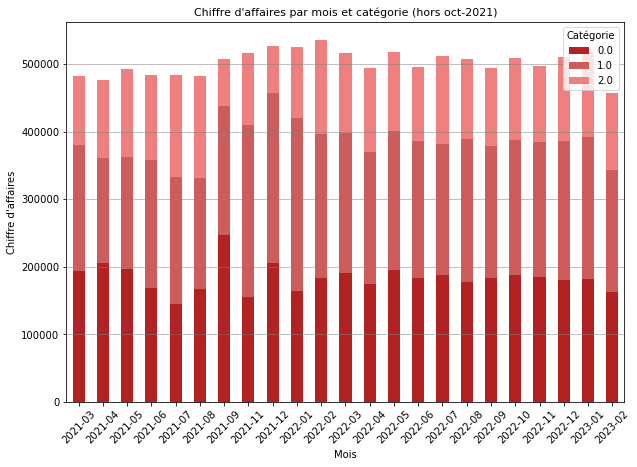

In [34]:
# Représentation du CA mensuel de chaque catégorie de produit
df_final_ok.pivot_table(index='mois', columns='categ',values='price', aggfunc='sum')\
         .plot.bar(stacked=True,color=['firebrick', "indianred", "lightcoral"],rot=45, figsize=(10,7))
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Chiffre d'affaires par mois et catégorie (hors oct-2021)",fontsize=11)
plt.show()

##### Chiffre d'affaires par catégorie (après nettoyage) <a class="anchor" id="3_2_2_4"></a>

In [35]:
# Observations des indicateurs statistiques et graphiques pour chaque catégorie
print("Chiffre d'affaires par catégorie : indicateurs ")

for cat in df_products['categ'].unique():
    subset = df_final_ok[df_final_ok.categ == cat]
    subset = subset.groupby(subset['date'].dt.strftime('%Y-%m'))['price'].sum().reset_index()
    print("-"*20)
    print("Catégorie",int(cat))
    print("min:",subset['price'].min())
    print("max:",subset['price'].max())
    print("moy:",round(subset['price'].mean(),2))
    print("med:",round(subset['price'].median(),2))
    print("var:",round(subset['price'].var(ddof=0),2))
    print("ect:",round(subset['price'].std(ddof=0),2))


Chiffre d'affaires par catégorie : indicateurs 
--------------------
Catégorie 0
min: 144792.07
max: 246477.75
moy: 183595.16
med: 183422.12
var: 396604721.88
ect: 19914.94
--------------------
Catégorie 1
min: 156138.35
max: 256267.91999999998
moy: 200867.84
med: 199609.66
var: 630320647.52
ect: 25106.19
--------------------
Catégorie 2
min: 68854.29
max: 151555.79
moy: 117064.76
med: 117506.33
var: 367240408.49
ect: 19163.52


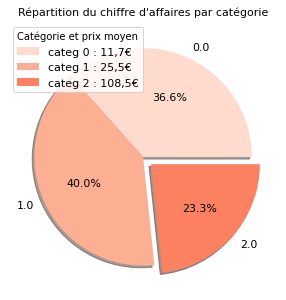

In [36]:
# Répartition du chiffre d'affaires par catégorie
data = df_final_ok.groupby('categ')['price'].sum().reset_index()
colors = sns.color_palette("Reds")
plt.figure(figsize=(10,5))

plt.pie(x=data['price'], 
        labels=data['categ'],
        colors = colors, 
        autopct='%.1f%%',
        textprops={'fontsize': 11},
        explode=(0,0,0.1), 
        shadow=True)

plt.title("Répartition du chiffre d'affaires par catégorie",fontsize=11)
plt.legend(title='Catégorie et prix moyen', 
           labels={"categ 0 : 11,7€","categ 1 : 25,5€","categ 2 : 108,5€"}, 
           fontsize=11,
           loc="upper left")
plt.savefig('pie_CA_categ.png')
plt.show()

La catégorie 1 est celle qui a le plus grand chiffre d'affaires.
Le chiffre d'affaires mensuel moyen pour chaque catégorie est de :
- Catégorie 0: 183 595 €
- Catégorie 1: 200 867 €
- Catégorie 2: 117 064 €

In [37]:
# Aggrégation par mois et catégorie de produit
categ=df_final_ok.groupby(['categ','mois'])['price'].sum().reset_index().rename(columns={'price':'CA mensuel'})

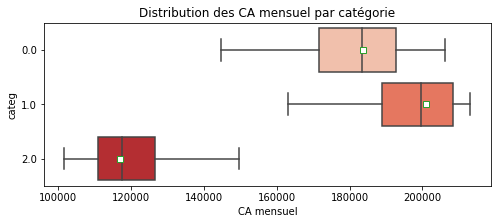

In [38]:
# Distribution et moyenne des CA mensuel par catégorie
plt.figure(figsize=(8,3))
sns.boxplot(data=categ, y='categ', x='CA mensuel', 
            orient='h', 
            showmeans=True,
            showfliers=False,
            palette="Reds", 
            meanprops={"marker":"s","markerfacecolor":"white"})
plt.title('Distribution des CA mensuel par catégorie')
plt.savefig('CA_mensuel_categ_boxplot.png')
plt.show()

##### Tendance globale du chiffre d'affaires mensuel - décomposition en moyenne mobile<a class="anchor" id="3_2_2_5"></a>

Pour le calcul de la moyenne mobile, la fonction **.rolling().mean()** sera utilisée et la période choisie pour le calcul est de 3 mois.

In [39]:
# Moyenne mobile sur 3 mois
ca_mensuel_ok['3m_rolling_avg'] = ca_mensuel_ok['CA mensuel'].rolling(3).mean()
  
# viewing the dataset
ca_mensuel_ok.head()

mois  CA mensuel  3m_rolling_avg
0  2021-03   482533.49             NaN
1  2021-04   476253.78             NaN
2  2021-05   493026.03   483937.766667
3  2021-06   484160.80   484480.203333
4  2021-07   482876.68   486687.836667

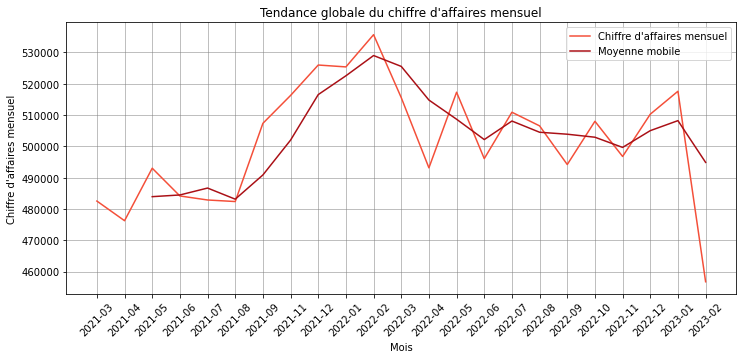

In [40]:
plt.figure(figsize = ( 12, 5))
  
# courbe données
plt.plot(ca_mensuel_ok['mois'], ca_mensuel_ok['CA mensuel'],
        label = "Chiffre d'affaires mensuel",
        color='#f44f39')
  
# Moyenne mobile
plt.plot(ca_mensuel_ok['mois'], ca_mensuel_ok['3m_rolling_avg'],
        label = 'Moyenne mobile',
        color='#aa1016')

plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.ylabel("Chiffre d'affaires mensuel")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.title("Tendance globale du chiffre d'affaires mensuel",fontsize=12)
plt.legend()
plt.show()

La tendance globale du chiffre d'affaires mensuel est stable depuis juin 2022 et entre 500 000 € à 510 000 € par mois.

#### c. Chiffre d'affaires journalier<a class="anchor" id="3_2_3"></a>

In [41]:
# Aggrégation par jour pour obtenir le ca journalier
ca_jour = df_final_ok.groupby('jour')['price'].sum().reset_index().rename(columns={'price':'CA jour'})

##### Indicateurs statistiques<a class="anchor" id="3_2_3_1"></a>

In [42]:
# calcul des indicateurs
print("Indicateurs du chiffre d'affaires journalier")
print("-"*43)
print(ca_jour['CA jour'].describe(include='all'))
print("")
print("median:",round(ca_jour['CA jour'].median(),2))
print("variance:",round(ca_jour['CA jour'].var(ddof=0),2))

Indicateurs du chiffre d'affaires journalier
-------------------------------------------
count      699.000000
mean     16502.343948
std       1291.361828
min      13792.210000
25%      15569.500000
50%      16338.900000
75%      17253.060000
max      20498.000000
Name: CA jour, dtype: float64

median: 16338.9
variance: 1665229.66


##### Tendance globale du chiffre d'affaires journalier - décomposition en moyenne mobile<a class="anchor" id="3_2_3_2"></a>

Pour la décomposition en moyenne mobile du chiffre d'affaires journalier, l'échelle de temps considérée sera de 3 mois.

Le chiffre d'affaires journalier oscille entre 15 000€ et 17 500€. Il est stable sur la période mars 2022 à février 2023.

Un pic du chiffre d'affaires journalier est observé en février-mars 2022 : jusqu'à 20 000€. Nous ne disposons pas d'assez de données pour déterminer si cela est saisonnier ou non.

In [43]:
# Moyenne mobile sur 3 mois
ca_jour['3m_rolling_avg'] = ca_jour['CA jour'].rolling(90).mean()
  
# viewing the dataset
ca_jour.head(10)

jour   CA jour  3m_rolling_avg
0  2021-03-01  16575.54             NaN
1  2021-03-02  15496.77             NaN
2  2021-03-03  15198.69             NaN
3  2021-03-04  15196.07             NaN
4  2021-03-05  17471.37             NaN
5  2021-03-06  15785.28             NaN
6  2021-03-07  14770.52             NaN
7  2021-03-08  15679.53             NaN
8  2021-03-09  15710.51             NaN
9  2021-03-10  15496.87             NaN

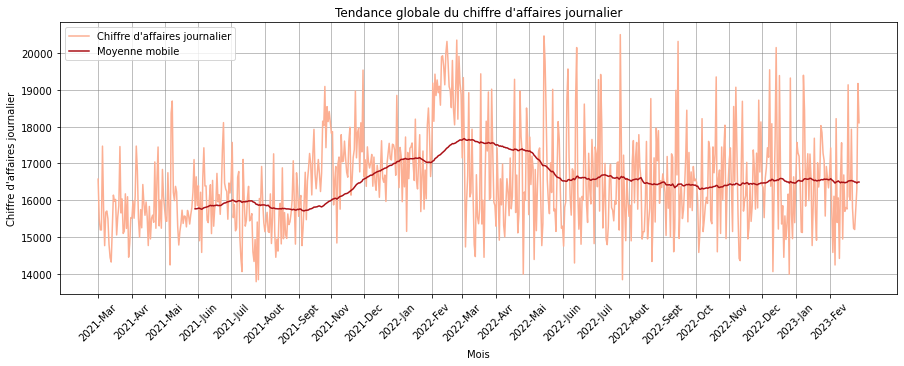

In [44]:
plt.figure(figsize = ( 15, 5))
  
# courbe données
plt.plot(ca_jour['jour'], ca_jour['CA jour'],
        label = "Chiffre d'affaires journalier",
        color='#fcaf93')
  
# Moyenne mobile
plt.plot(ca_jour['jour'], ca_jour['3m_rolling_avg'],
        label = 'Moyenne mobile',
        color='#aa1016')

# setting customized ticklabels for x axis
pos = [ '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', 
       '2021-07-01', '2021-08-01', '2021-09-01', 
       '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
       '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', 
       '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
       '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01']
  
lab = [ '2021-Mar', '2021-Avr', '2021-Mai', '2021-Juin', '2021-Juil', '2021-Aout', 
       '2021-Sept', '2021-Nov', '2021-Dec', '2022-Jan', '2022-Fev',
       '2022-Mar', '2022-Avr', '2022-Mai', '2022-Juin', '2022-Juil', '2022-Aout',
       '2022-Sept', '2022-Oct', '2022-Nov', '2022-Dec', '2023-Jan', '2023-Fev',]
  
plt.xticks( pos, lab, rotation=45)
plt.xlabel('Mois')
plt.ylabel("Chiffre d'affaires journalier")
plt.title("Tendance globale du chiffre d'affaires journalier",fontsize=12)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.legend()
plt.savefig('CA_jour_moy.png')
plt.show()

### 3. Ventes<a class="anchor" id="3_3"></a>

#### a. Ventes mensuelles<a class="anchor" id="3_3_1"></a>

#####  Indicateurs statistiques<a class="anchor" id="3_3_1_1"></a>

Par mois, il y a entre 24 700 à 33 300 ventes avec une moyenne à 28 500 ventes / mois.

In [45]:
# Aggrégation par mois pour obtenir le nombre de ventes mensuelles
trans_mensuel = df_final_ok.groupby('mois')['date'].count().reset_index().rename(columns={'date':'nb_ventes'})

In [46]:
# calcul des indicateurs
print("Indicateurs du nombre de ventes mensuelles")
print("-"*43)
print(trans_mensuel['nb_ventes'].describe(include='all'))
print("")
print("median:",round(trans_mensuel['nb_ventes'].median(),2))
print("variance:",round(trans_mensuel['nb_ventes'].var(ddof=0),2))

Indicateurs du nombre de ventes mensuelles
-------------------------------------------
count       23.000000
mean     28596.782609
std       1899.479138
min      24742.000000
25%      28304.000000
50%      28574.000000
75%      29161.000000
max      33326.000000
Name: nb_ventes, dtype: float64

median: 28574.0
variance: 3451150.52


##### Chiffre d'affaires mensuel et nombre de ventes mensuelles<a class="anchor" id="3_3_1_2"></a>

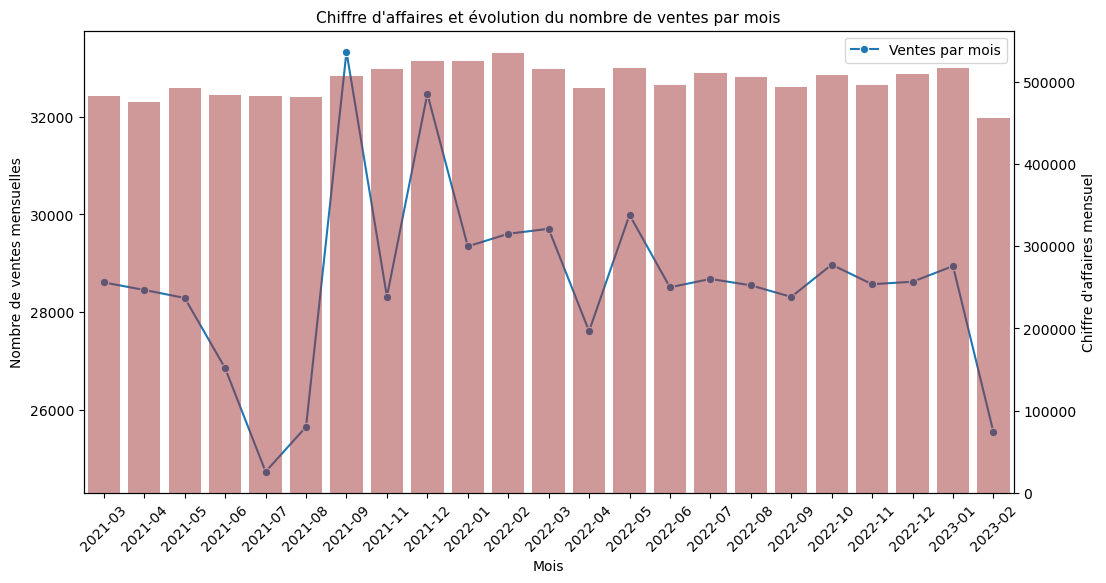

In [47]:
# Réprésentation du chiffre d'affaire et du nombre de ventes par mois
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

# .subplots() pour afficher plusieurs graphiques dans la fenêtre
fig, ax1 = plt.subplots(figsize=(12,6))

# Courbe Nombre de ventes mensuelles par mois : ax1
sns.lineplot(data = trans_mensuel['nb_ventes'], marker='o', sort = False, ax=ax1,label='Ventes par mois')
plt.ylabel("Nombre de ventes mensuelles")
plt.xlabel("Mois")
plt.xticks(rotation=45)
plt.legend()
# .twinx() pour ajouter le 2ième axe des ordonnées
ax2 = ax1.twinx()

# Diagramme en barres Chiffre d'affaires mensuel : ax2
sns.barplot(data=ca_mensuel_ok, x='mois',y='CA mensuel', alpha=0.5, ax=ax2,color='firebrick')
plt.ylabel("Chiffre d'affaires mensuel")
plt.title("Chiffre d'affaires et évolution du nombre de ventes par mois",fontsize=11)
plt.savefig('CA_ventes_mois.png')
plt.show()

#### b. Ventes par références  : tops et flops<a class="anchor" id="3_3_2"></a>

In [48]:
# Aggrégation par identifiant produit et catégorie
df_ref = df_final_ok.groupby(['id_prod','categ','price'])['date'].count().reset_index().sort_values(['date'], ascending=False)
df_ref.rename(columns={'date': 'nb_ventes'}, inplace=True)

- Top des ventes :

Les 10 produits les plus vendus sont de catégorie 1.

In [49]:
print("Tops des ventes par référence :")
tops_=df_ref.head(10)
tops_

Tops des ventes par référence :


id_prod  categ  price  nb_ventes
2607   1_369    1.0  23.99       2237
2661   1_417    1.0  20.99       2173
2658   1_414    1.0  23.83       2166
2750   1_498    1.0  23.37       2117
2670   1_425    1.0  16.99       2084
2646   1_403    1.0  17.99       1950
2656   1_412    1.0  16.65       1938
2649   1_406    1.0  24.81       1931
2657   1_413    1.0  17.99       1931
2650   1_407    1.0  15.99       1923

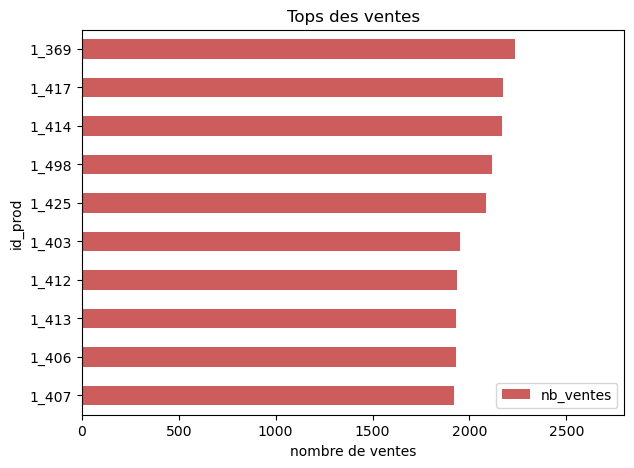

In [50]:
# Représentation graphique des ventes pour le top des références
tops_=tops_.sort_values('nb_ventes')
tops_.plot( x = 'id_prod', y = 'nb_ventes', kind = 'barh', color='indianred',figsize=(7,5))
plt.xlabel('nombre de ventes')
plt.xlim(0,2800)
plt.title('Tops des ventes')
plt.show()

- Flops des ventes

Nous retrouvons ici les 21 références pour lesquels aucune vente n'a été réalisée.

Sur les 21 références, il y a :
- catégorie 0 : 16 références
- catégorie 1 : 2 références
- catégorie 2 : 3 références

In [51]:
print("Flops par référence :")
flops_=df_ref.tail(21).sort_values('price')
display(flops_)
flops_.groupby('categ')['id_prod'].count().reset_index()

Flops par référence :


id_prod  categ   price  nb_ventes
691   0_1620    0.0    0.80          0
19    0_1014    0.0    1.15          0
868   0_1780    0.0    1.67          0
1543   0_310    0.0    1.94          0
135   0_1119    0.0    2.99          0
718   0_1645    0.0    2.99          0
1556   0_322    0.0    2.99          0
72    0_1062    0.0   20.08          0
1454  0_2308    0.0   20.28          0
356   0_1318    0.0   20.92          0
891   0_1800    0.0   22.05          0
1529   0_299    0.0   22.99          0
1765   0_510    0.0   23.66          0
695   0_1624    0.0   24.50          0
31    0_1025    0.0   24.99          0
2307     1_0    1.0   31.82          0
21    0_1016    0.0   35.06          0
2635   1_394    1.0   39.73          0
3270    2_86    2.0  132.36          0
3255    2_72    2.0  141.32          0
3271    2_87    2.0  220.99          0

categ  id_prod
0    0.0       16
1    1.0        2
2    2.0        3

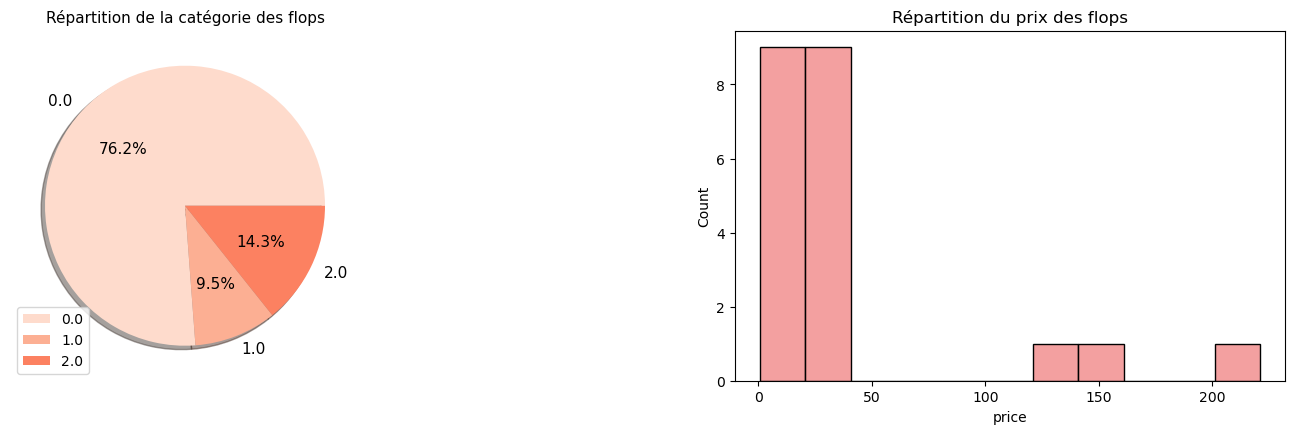

In [52]:
# création de la fenêtre graphique 1
plt.figure(1,figsize=(10,5))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

# division de la fenêtre graphique en 1 ligne, 2 colonnes,
# graphique en position 1
# puis caractéristiques de ce graphique
plt.subplot(1,2,1)
colors = sns.color_palette("Reds")
data = flops_.groupby('categ')['id_prod'].count().reset_index()
plt.pie(x=data['id_prod'],labels=data['categ'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        shadow=True)
plt.title("Répartition de la catégorie des flops",fontsize=11)
plt.legend (loc='lower left')

# graphique en position 2
# puis caractéristiques de ce graphique
plt.subplot(1,2,2)
sns.histplot(data=flops_,x='price',color='lightcoral')
plt.title('Répartition du prix des flops')
plt.savefig('flops.png')
plt.show()

##### Tops et flops des références pour chaque catégorie

In [53]:
# Observations des indicateurs statistiques et graphiques pour chaque catégorie
print("Ventes mensuelles par référence et par catégorie : indicateurs et graphique")

for cat in df_products['categ'].unique():
    subset = df_ref[df_ref.categ == cat]
    print("-"*20)
    print("Catégorie",int(cat))
    print("min:",subset['nb_ventes'].min())
    print("max:",subset['nb_ventes'].max())
    print("moy:",round(subset['nb_ventes'].mean(),2))
    print("med:",round(subset['nb_ventes'].median(),2))
    print("var:",round(subset['nb_ventes'].var(ddof=0),2))
    print("ect:",round(subset['nb_ventes'].std(ddof=0),2))
    print("")
    print("Catégorie",int(cat),": Top des ventes")
    display(subset.head(10))
    print("")
    print("Catégorie",int(cat),": Flop des ventes")
    display(subset.tail(10))

Ventes mensuelles par référence et par catégorie : indicateurs et graphique
--------------------
Catégorie 0
min: 0
max: 1234
moy: 172.05
med: 47.0
var: 68913.25
ect: 262.51

Catégorie 0 : Top des ventes


id_prod  categ  price  nb_ventes
481  0_1431    0.0  10.99       1234
471  0_1422    0.0  11.41       1233
474  0_1425    0.0  12.99       1215
0       0_0    0.0   3.75       1194
473  0_1424    0.0   8.41       1193
482  0_1432    0.0  15.36       1191
459  0_1411    0.0   8.99       1191
492  0_1441    0.0  18.99       1179
477  0_1428    0.0   3.55       1178
484  0_1434    0.0   8.58       1177


Catégorie 0 : Flop des ventes


id_prod  categ  price  nb_ventes
1454  0_2308    0.0  20.28          0
1529   0_299    0.0  22.99          0
1556   0_322    0.0   2.99          0
356   0_1318    0.0  20.92          0
1765   0_510    0.0  23.66          0
19    0_1014    0.0   1.15          0
21    0_1016    0.0  35.06          0
135   0_1119    0.0   2.99          0
31    0_1025    0.0  24.99          0
1543   0_310    0.0   1.94          0

--------------------
Catégorie 1
min: 0
max: 2237
moy: 305.15
med: 85.0
var: 216844.5
ect: 465.67

Catégorie 1 : Top des ventes


id_prod  categ  price  nb_ventes
2607   1_369    1.0  23.99       2237
2661   1_417    1.0  20.99       2173
2658   1_414    1.0  23.83       2166
2750   1_498    1.0  23.37       2117
2670   1_425    1.0  16.99       2084
2646   1_403    1.0  17.99       1950
2656   1_412    1.0  16.65       1938
2649   1_406    1.0  24.81       1931
2657   1_413    1.0  17.99       1931
2650   1_407    1.0  15.99       1923


Catégorie 1 : Flop des ventes


id_prod  categ  price  nb_ventes
2622   1_382    1.0  61.52          4
2360   1_146    1.0  31.98          3
2652   1_409    1.0  55.99          3
2651   1_408    1.0  35.24          3
2647   1_404    1.0   9.85          3
2645   1_402    1.0  34.52          2
2665   1_420    1.0   7.12          2
2769   1_514    1.0  67.66          2
2635   1_394    1.0  39.73          0
2307     1_0    1.0  31.82          0

--------------------
Catégorie 2
min: 0
max: 997
moy: 147.75
med: 42.0
var: 49013.78
ect: 221.39

Catégorie 2 : Top des ventes


id_prod  categ  price  nb_ventes
3051   2_102    2.0  59.14        997
3087   2_135    2.0  68.99        977
3062   2_112    2.0  67.57        930
3218    2_39    2.0  57.99        882
3216    2_37    2.0  48.99        867
3060   2_110    2.0  62.25        834
3168   2_208    2.0  54.87        805
3169   2_209    2.0  69.99        791
3167   2_207    2.0  50.99        761
3058   2_109    2.0  53.99        718


Catégorie 2 : Flop des ventes


id_prod  categ   price  nb_ventes
3260    2_77    2.0  145.99          2
3278    2_93    2.0   78.99          2
3248    2_66    2.0  150.72          2
3083   2_131    2.0  127.99          2
3265    2_81    2.0   86.99          1
3283    2_98    2.0  149.74          1
3192    2_23    2.0  115.99          1
3271    2_87    2.0  220.99          0
3270    2_86    2.0  132.36          0
3255    2_72    2.0  141.32          0

#### c. Répartition des ventes par catégorie<a class="anchor" id="3_3_3"></a>

#####  Ventes mensuelles par catégorie de produits<a class="anchor" id="3_3_1_2"></a>

In [54]:
# Observations des indicateurs statistiques et graphiques pour chaque catégorie
print("Ventes mensuelles par catégorie : indicateurs et graphique")

for cat in df_products['categ'].unique():
    subset = df_final_ok[df_final_ok.categ == cat]
    subset = subset.groupby(subset['date'].dt.strftime('%Y-%m'))['price'].count().reset_index()
    print("-"*20)
    print("Catégorie",int(cat))
    print("min:",subset['price'].min())
    print("max:",subset['price'].max())
    print("moy:",round(subset['price'].mean(),2))
    print("med:",round(subset['price'].median(),2))
    print("var:",round(subset['price'].var(ddof=0),2))
    print("ect:",round(subset['price'].std(ddof=0),2))

Ventes mensuelles par catégorie : indicateurs et graphique
--------------------
Catégorie 0
min: 13582
max: 23154
moy: 17257.0
med: 17278.0
var: 3528406.61
ect: 1878.41
--------------------
Catégorie 1
min: 7579
max: 12560
moy: 9804.48
med: 9726.0
var: 1522745.38
ect: 1234.0
--------------------
Catégorie 2
min: 896
max: 1991
moy: 1535.3
med: 1525.0
var: 65247.26
ect: 255.44


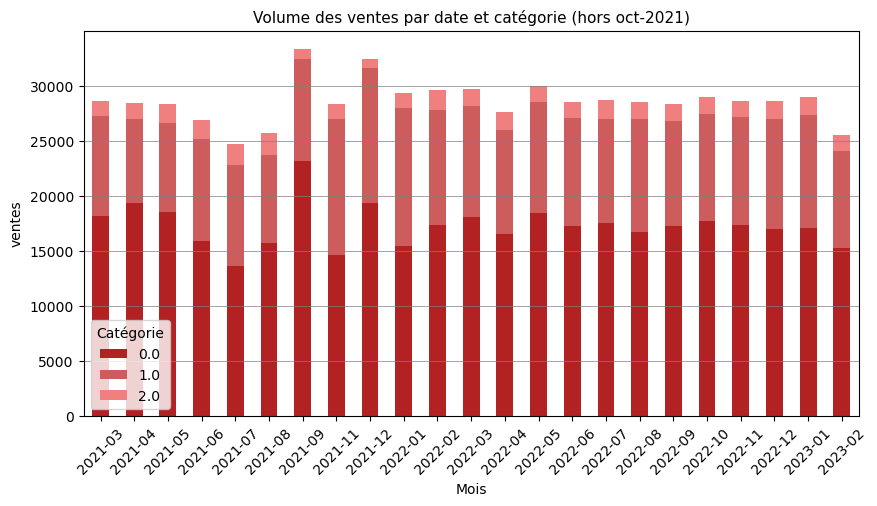

In [55]:
#Volume des ventes par mois et catégorie 
df_final_ok.pivot_table(index='mois', columns='categ',values='date', aggfunc='count')\
         .plot.bar(stacked=True,color=['firebrick', "indianred", "lightcoral"],rot=45, figsize=(10,5))
plt.xlabel("Mois")
plt.ylabel("ventes")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Volume des ventes par date et catégorie (hors oct-2021)",fontsize=11)
plt.show()

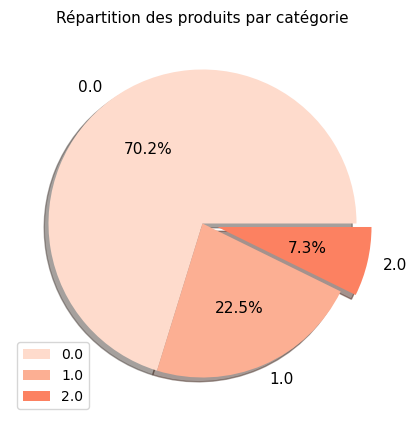

In [56]:
# Répartition des produits par catégorie
plt.figure(1,figsize=(10,5))
colors = sns.color_palette("Reds")
categ_ = df_ref.groupby('categ')['id_prod'].count().reset_index()
plt.pie(x=categ_['id_prod'],labels=categ_['categ'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0,0.1),shadow=True)
plt.title("Répartition des produits par catégorie",fontsize=11)
plt.legend (loc='lower left')
plt.show()

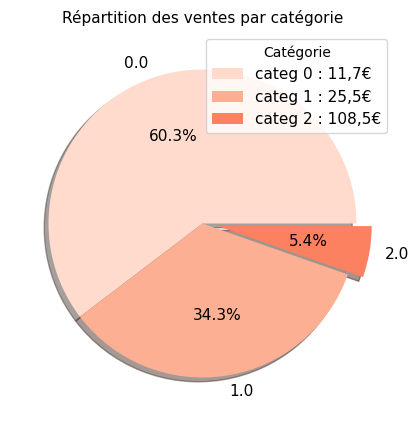

In [57]:
# Diagramme en secteurs pour représenter la répartition des ventes par catégorie
data = df_final_ok.groupby('categ')['date'].count().reset_index()
plt.figure(figsize=(10,5))
colors = sns.color_palette("Reds")
plt.pie(x=data['date'], 
        labels=data['categ'],
        colors = colors, 
        autopct='%.1f%%',
        textprops={'fontsize': 11},
        explode=(0,0,0.1), 
        shadow=True)

plt.title("Répartition des ventes par catégorie",fontsize=11)
plt.legend(title='Catégorie',
           labels={"categ 0 : 11,7€","categ 1 : 25,5€","categ 2 : 108,5€"},
           fontsize=11,
           loc="upper right")
plt.savefig('pie_ventes_categ.png')
plt.show()

In [58]:
# Aggrégation par mois et catégorie de produit
categ=df_final_ok.groupby(['categ','mois'])['date'].count().reset_index().rename(columns={'date':'nb_ventes'})

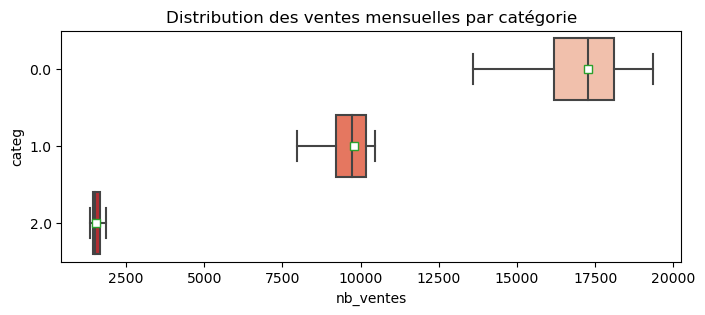

In [59]:
# Distribution et moyenne des CA mensuel par catégorie
plt.figure(figsize=(8,3))
sns.boxplot(data=categ, y='categ', x='nb_ventes', 
            orient='h', 
            showmeans=True,
            showfliers=False,
            palette="Reds", 
            meanprops={"marker":"s","markerfacecolor":"white"})
plt.title('Distribution des ventes mensuelles par catégorie')
plt.savefig('ventes_mois_categ_boxplot.png')
plt.show()

La catégorie 0 est celle qui a le plus grand volume de ventes par mois, 60% du volume total des ventes

En résumé :

|Categorie|Moyenne ventes mensuelles|% des ventes totales|% du CA total|
|:-:|:-:|:-:|:-:|
|0|17 300|60,4|36,6|
|1|9 500|34,1|40,1|
|2|1 500|5,4|23,3|



### 4. Profils clients<a class="anchor" id="3_4"></a>

#### b. Création du df_client<a class="anchor" id="3_4_2"></a>

##### Calcul des informations d'achat par client

Les informations suivantes sont nécessaires pour l'analyse des achats des clients :
- montant total des achats
- montant du panier moyen
- taille du panier moyen
- fréquence des achats
- classe d'âges des clients et regroupement

In [60]:
# Aggrégation par identifiant client 
client = df_final_ok.groupby(['client_id','sex','age'])['price'].sum()\
    .reset_index().rename(columns={'price':'montant_total_achat'})
client.shape

(8621, 4)

In [61]:
# affectation des tranches d'âge entre -31 ans à +81 ans - discrétisation par tranche de 10 ans
client['classe_age'] = 0
client.loc[client['age'] <= 31, 'classe_age'] = '- 31'
client.loc[(client['age'] > 31) & (client['age'] <= 41), 'classe_age'] = '32-41'
client.loc[(client['age'] > 41) & (client['age'] <= 51), 'classe_age'] = '42-51'
client.loc[(client['age'] > 51) & (client['age'] <= 61), 'classe_age'] = '52-61'
client.loc[(client['age'] > 61) & (client['age'] <= 71), 'classe_age'] = '62-71'
client.loc[(client['age'] > 71) & (client['age'] <= 81), 'classe_age'] = '72-81'
client.loc[(client['age'] > 81), 'classe_age'] = '82+'

In [62]:
# Regroupement en 3 groupes d'âges
client['groupe_age'] = 0
client.loc[client['age'] <= 31, 'groupe_age'] = '- 31'
client.loc[(client['age'] > 31) & (client['age'] <= 51), 'groupe_age'] = '32-51'
client.loc[(client['age'] > 51), 'groupe_age'] = '52+'

In [63]:
# Panier moyen et Taille du panier moyen
panier=df_final_ok.groupby(
    ['client_id','session_id']).agg({'price': 'sum','id_prod': 'count'}
    ).reset_index().rename(columns={'price':'panier_moyen','id_prod':'taille_panier_moyen'}
    ).pivot_table(index='client_id',aggfunc='mean')
panier.shape

(8598, 2)

In [64]:
# Fréquence d'achat sur la période
freq=df_final_ok.groupby(
    ['client_id'])['session_id'].count().reset_index().rename(
    columns={'session_id':'freq_achat'})
freq.shape

(8621, 2)

##### Regroupement des informations dans un même data frame

In [65]:
# Jointure du data frame client et du data frame panier
df=pd.merge(client,panier,on='client_id',how='outer',indicator=True)
df.shape

(8621, 9)

In [66]:
#Filtrage sur les valeurs de la colonne '_merge' qui sont différentes de 'both'
print("Il y a ",df.loc[df['_merge']!='both',:].shape[0]," lignes qui ne sont pas dans les 2 df.")

Il y a  23  lignes qui ne sont pas dans les 2 df.


In [67]:
print("Pour les clients uniquement présents dans le df client :")
print("- nombre de clients :",df.loc[df['_merge']=='left_only',:].shape[0])

Pour les clients uniquement présents dans le df client :
- nombre de clients : 23


Dans le df client, il y a les 23 clients qui n'ont pas effectué d'achats sur la période d'analyse : cela correspond aux résultats observés ici.

In [68]:
# Suppression de la colonne _merge
df.pop('_merge')

# Jointure du data frame client et du data frame panier
df_client=pd.merge(df,freq,on='client_id',how='outer',indicator=True)
df_client.shape

(8621, 10)

In [69]:
#Filtrage sur les valeurs de la colonne '_merge' qui sont différentes de 'both'
print("Il y a ",df_client.loc[df_client['_merge']!='both',:].shape[0]," lignes qui ne sont pas dans les 2 df.")

Il y a  0  lignes qui ne sont pas dans les 2 df.


In [70]:
print("Pour les clients uniquement présents dans le df client :")
print("- nombre de clients :",df_client.loc[df_client['_merge']=='left_only',:].shape[0])

Pour les clients uniquement présents dans le df client :
- nombre de clients : 0


In [71]:
# Suppression de la colonne _merge
df_client.pop('_merge')

# Aperçu du df
df_client.head()

client_id sex   age  montant_total_achat classe_age groupe_age  \
0       c_1   m  68.0               550.19      62-71        52+   
1      c_10   m  67.0              1353.60      62-71        52+   
2     c_100   m  31.0               254.85       - 31       - 31   
3    c_1000   f  57.0              2209.92      52-61        52+   
4    c_1001   m  41.0              1720.08      32-41      32-51   

   panier_moyen  taille_panier_moyen  freq_achat  
0     17.193438             1.187500          38  
1     39.811765             1.705882          58  
2     50.970000             1.600000           8  
3     24.284835             1.340659         122  
4     39.092727             2.181818          96

#### c. Identification des profils client<a class="anchor" id="3_4_3"></a>

Pour identifier les profils clients, nous allons observer les différentes variables.

In [72]:
# Indicateurs statistiques 
df_client.describe(include='all')

client_id   sex          age  montant_total_achat classe_age  \
count       8621  8621  8621.000000          8621.000000       8621   
unique      8621     2          NaN                  NaN          7   
top          c_1     f          NaN                  NaN       - 31   
freq           1  4489          NaN                  NaN       2282   
mean         NaN   NaN    44.719406          1338.027888        NaN   
std          NaN   NaN    16.920581          5028.252836        NaN   
min          NaN   NaN    19.000000             0.000000        NaN   
25%          NaN   NaN    31.000000           530.740000        NaN   
50%          NaN   NaN    44.000000           998.140000        NaN   
75%          NaN   NaN    57.000000          1728.950000        NaN   
max          NaN   NaN    94.000000        312755.080000        NaN   

       groupe_age  panier_moyen  taille_panier_moyen    freq_achat  
count        8621   8598.000000          8598.000000   8621.000000  
unique          3           NaN                  NaN           NaN  
top         32-51           NaN                  NaN           NaN  
freq         3365           NaN                  NaN           NaN  
mean          NaN     40.619371             1.987134     76.293469  
std           NaN     23.479083             0.678394    300.533098  
min           NaN      4.150000             1.000000      0.000000  
25%           NaN     25.540300             1.406250     26.000000  
50%           NaN     32.286515             1.958333     50.000000  
75%           NaN     48.789940             2.428571     92.000000  
max           NaN    259.422500             8.200000  24472.000000

In [73]:
df_client.isna().sum()

client_id               0
sex                     0
age                     0
montant_total_achat     0
classe_age              0
groupe_age              0
panier_moyen           23
taille_panier_moyen    23
freq_achat              0
dtype: int64

##### Clients qui n'ont fait aucun achat en ligne

Observons les clients qui n'ont effectué aucun achat en ligne :
- il y a autant d'hommes que de femmes
- il s'agit en majorité de clients < 30 ans et > 60 ans.

Pour la suite des analyses, nous ne conserverons pas ces clients.

In [74]:
# Clients qui n'ont fait aucun achat en ligne
print("Il y a ",df_client.loc[df_client['montant_total_achat']==0].shape[0],\
      " clients qui ont effectué aucun achat sur la boutique en ligne.")

Il y a  23  clients qui ont effectué aucun achat sur la boutique en ligne.


In [75]:
# Filtrage sur les clients n'ayant effectué aucun achat en ligne
df0=df_client.loc[df_client['montant_total_achat']==0,:]

In [76]:
# Nombre de client n'ayant effectué aucun achat en ligne par tranche d'âge
df0.groupby('classe_age')['client_id'].count().reset_index().rename(columns={'client_id':'nombre'})

classe_age  nombre
0       - 31      15
1      52-61       3
2      62-71       5

In [77]:
# Nombre de client n'ayant effectué aucun achat en ligne par genre
df0.groupby('sex')['client_id'].count().reset_index().rename(columns={'client_id':'nombre'})

sex  nombre
0   f      12
1   m      11

In [78]:
# Filtrage sur les clients ayant effectué des achats en ligne
df_client=df_client.loc[df_client['montant_total_achat']!=0,:]

##### Chiffre d'affaires

Nous observons 4 clients qui ont des chiffres d'affaires plus de 20 fois supérieurs aux autres : c_1609, c_4958, c_6714, c_3454.

In [79]:
# Tri par chiffre d'affaires décroissant
df_client.sort_values('montant_total_achat',ascending=False)

client_id sex   age  montant_total_achat classe_age groupe_age  \
678     c_1609   m  43.0            312755.08      42-51      32-51   
4397    c_4958   m  24.0            282654.61       - 31       - 31   
6349    c_6714   f  55.0            149845.67      52-61        52+   
2727    c_3454   m  54.0            111797.67      52-61        52+   
2110    c_2899   f  29.0              5214.05       - 31       - 31   
...        ...  ..   ...                  ...        ...        ...   
1993    c_2793   m  90.0                12.99        82+        52+   
4053    c_4648   m  19.0                11.20       - 31       - 31   
1557     c_240   m  25.0                11.06       - 31       - 31   
7905    c_8114   m  61.0                 9.98      52-61        52+   
7934    c_8140   m  52.0                 8.30      52-61        52+   

      panier_moyen  taille_panier_moyen  freq_achat  
678      29.678789             2.322262       24472  
4397     75.094211             1.352285        5090  
6349     59.675695             3.545599        8903  
2727     20.535942             1.218773        6635  
2110     75.565942             1.521739         105  
...            ...                  ...         ...  
1993     12.990000             1.000000           1  
4053     11.200000             1.000000           1  
1557     11.060000             1.000000           1  
7905      4.990000             1.000000           2  
7934      4.150000             1.000000           2  

[8598 rows x 9 columns]

Nous retrouvons ici les 4 clients qui ont un chiffre d'affaires bien supérieurs aux autres.

Nous observons 2 catégories de clients que nous pouvons séparer de la manière suivante :
- Particuliers : B2C, business to customer
- Professionnels : B2B, business to business

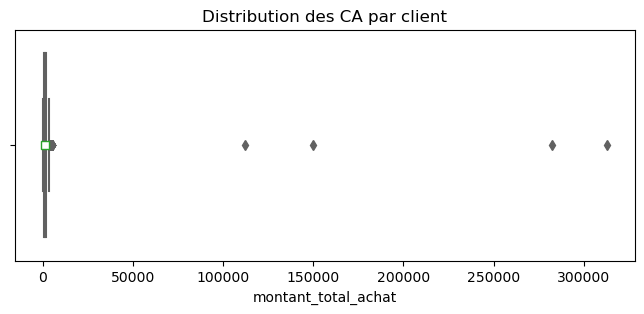

In [80]:
# Distribution et moyenne des CA par client
plt.figure(figsize=(8,3))
sns.boxplot(data=df_client, x='montant_total_achat', 
            orient='h', 
            showmeans=True, 
            palette="Reds", 
            meanprops={"marker":"s","markerfacecolor":"white"})
plt.title('Distribution des CA par client')
plt.show()

In [81]:
# Ajout d'une colonne 'profil_client'
df_client.loc[df_client['montant_total_achat']<10000,'profil_client']='B2C'
df_client.loc[df_client['montant_total_achat']>10000,'profil_client']='B2B'

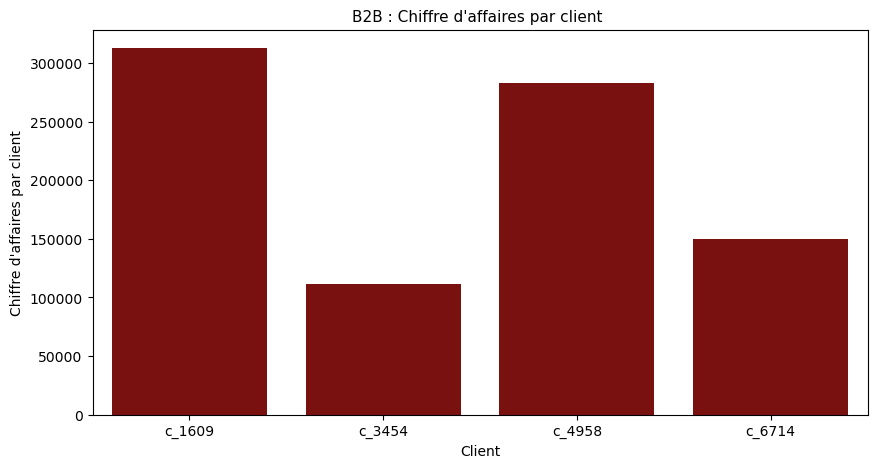

In [82]:
# Distrisbution du chiffre d'affaires par client B2B
plt.figure(figsize=(10,5))
sns.barplot(data=df_client.loc[df_client.profil_client=='B2B'],x='client_id',y='montant_total_achat',color='darkred',)
plt.xlabel("Client")
plt.ylabel("Chiffre d'affaires par client")
plt.title("B2B : Chiffre d'affaires par client ",fontsize=11)
plt.savefig('CA_B2B.png')
plt.show()


L'histogramme montre bien ce que nous avons observé sur le data frame : les clients B2C ont un montant total d'achats inférieur à 5 000€ sur l'ensemble de la période d'activité.

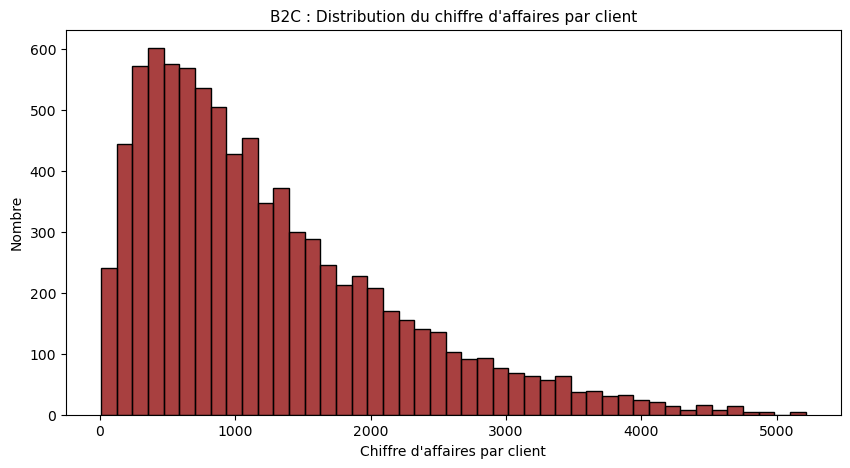

In [83]:
# Distribution du chiffre d'affaires par client
plt.figure(figsize=(10,5))
sns.histplot(data=df_client.loc[df_client.profil_client=='B2C'],x='montant_total_achat',color='darkred')
plt.xlabel("Chiffre d'affaires par client")
plt.ylabel("Nombre")
plt.title("B2C : Distribution du chiffre d'affaires par client",fontsize=11)
plt.show()

Les clients B2B :
- représentent le plus grand chiffre d'affaires
- ont la grande fréquence d'achats

Les clients B2C : 
- ont le plus grand panier moyen
- la plus grande taille de panier moyen

In [84]:
# Informations sur les clients B2B
df_client.loc[df_client.profil_client=='B2B'].describe(include='all')

client_id  sex        age  montant_total_achat classe_age groupe_age  \
count          4    4   4.000000             4.000000          4          4   
unique         4    2        NaN                  NaN          3          3   
top       c_1609    m        NaN                  NaN      52-61        52+   
freq           1    3        NaN                  NaN          2          2   
mean         NaN  NaN  44.000000        214263.257500        NaN        NaN   
std          NaN  NaN  14.399074         98364.692848        NaN        NaN   
min          NaN  NaN  24.000000        111797.670000        NaN        NaN   
25%          NaN  NaN  38.250000        140333.670000        NaN        NaN   
50%          NaN  NaN  48.500000        216250.140000        NaN        NaN   
75%          NaN  NaN  54.250000        290179.727500        NaN        NaN   
max          NaN  NaN  55.000000        312755.080000        NaN        NaN   

        panier_moyen  taille_panier_moyen    freq_achat profil_client  
count       4.000000             4.000000      4.000000             4  
unique           NaN                  NaN           NaN             1  
top              NaN                  NaN           NaN           B2B  
freq             NaN                  NaN           NaN             4  
mean       46.246159             2.109730  11275.000000           NaN  
std        25.482383             1.076169   8936.274727           NaN  
min        20.535942             1.218773   5090.000000           NaN  
25%        27.393077             1.318907   6248.750000           NaN  
50%        44.677242             1.837274   7769.000000           NaN  
75%        63.530324             2.628097  12795.250000           NaN  
max        75.094211             3.545599  24472.000000           NaN

In [85]:
# Informations sur les clients B2C
df_client.loc[df_client.profil_client=='B2C'].describe(include='all')

client_id   sex          age  montant_total_achat classe_age  \
count       8594  8594  8594.000000          8594.000000       8594   
unique      8594     2          NaN                  NaN          7   
top          c_1     f          NaN                  NaN       - 31   
freq           1  4476          NaN                  NaN       2266   
mean         NaN   NaN    44.739935          1242.504700        NaN   
std          NaN   NaN    16.911589           930.946938        NaN   
min          NaN   NaN    19.000000             8.300000        NaN   
25%          NaN   NaN    31.000000           533.967500        NaN   
50%          NaN   NaN    44.000000          1000.700000        NaN   
75%          NaN   NaN    57.000000          1729.252500        NaN   
max          NaN   NaN    94.000000          5214.050000        NaN   

       groupe_age  panier_moyen  taille_panier_moyen   freq_achat  \
count        8594   8594.000000          8594.000000  8594.000000   
unique          3           NaN                  NaN          NaN   
top         32-51           NaN                  NaN          NaN   
freq         3364           NaN                  NaN          NaN   
mean          NaN     40.616752             1.987077    71.285315   
std           NaN     23.479406             0.678249    65.614460   
min           NaN      4.150000             1.000000     1.000000   
25%           NaN     25.540300             1.406539    26.000000   
50%           NaN     32.286515             1.958333    50.000000   
75%           NaN     48.762386             2.428571    93.000000   
max           NaN    259.422500             8.200000   392.000000   

       profil_client  
count           8594  
unique             1  
top              B2C  
freq            8594  
mean             NaN  
std              NaN  
min              NaN  
25%              NaN  
50%              NaN  
75%              NaN  
max              NaN

##### Fréquence des achats

In [86]:
df_client.sort_values('freq_achat',ascending=False)

client_id sex   age  montant_total_achat classe_age groupe_age  \
678     c_1609   m  43.0            312755.08      42-51      32-51   
6349    c_6714   f  55.0            149845.67      52-61        52+   
2727    c_3454   m  54.0            111797.67      52-61        52+   
4397    c_4958   m  24.0            282654.61       - 31       - 31   
2516    c_3263   f  38.0              5129.89      32-41      32-51   
...        ...  ..   ...                  ...        ...        ...   
4053    c_4648   m  19.0                11.20       - 31       - 31   
695     c_1624   m  31.0                28.54       - 31       - 31   
3864    c_4478   f  53.0                13.36      52-61        52+   
1557     c_240   m  25.0                11.06       - 31       - 31   
5880    c_6292   m  31.0                24.24       - 31       - 31   

      panier_moyen  taille_panier_moyen  freq_achat profil_client  
678      29.678789             2.322262       24472           B2B  
6349     59.675695             3.545599        8903           B2B  
2727     20.535942             1.218773        6635           B2B  
4397     75.094211             1.352285        5090           B2B  
2516     37.173116             2.840580         392           B2C  
...            ...                  ...         ...           ...  
4053     11.200000             1.000000           1           B2C  
695      28.540000             1.000000           1           B2C  
3864     13.360000             1.000000           1           B2C  
1557     11.060000             1.000000           1           B2C  
5880     24.240000             1.000000           1           B2C  

[8598 rows x 10 columns]

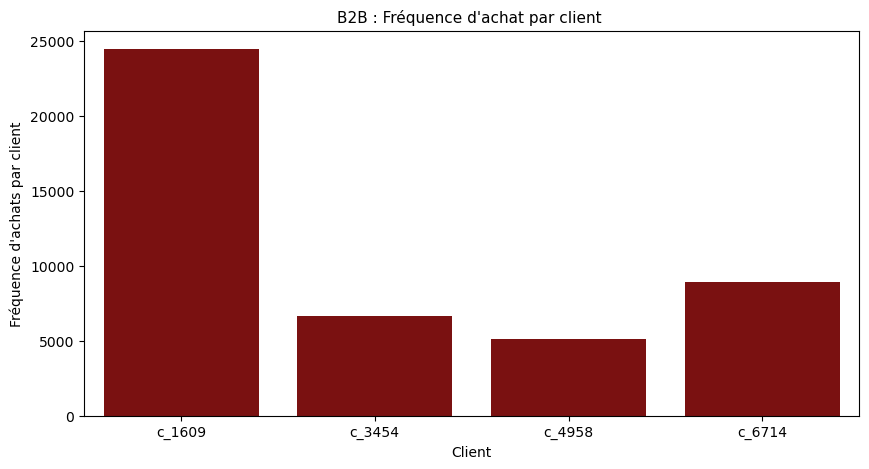

In [87]:
# Distrisbution de la fréquance d'achats par client B2B
plt.figure(figsize=(10,5))
sns.barplot(data=df_client.loc[df_client.profil_client=='B2B'],x='client_id',y='freq_achat',color='darkred',)
plt.xlabel("Client")
plt.ylabel("Fréquence d'achats par client")
plt.title("B2B : Fréquence d'achat par client ",fontsize=11)
plt.savefig('nb_achats_B2B.png')
plt.show()

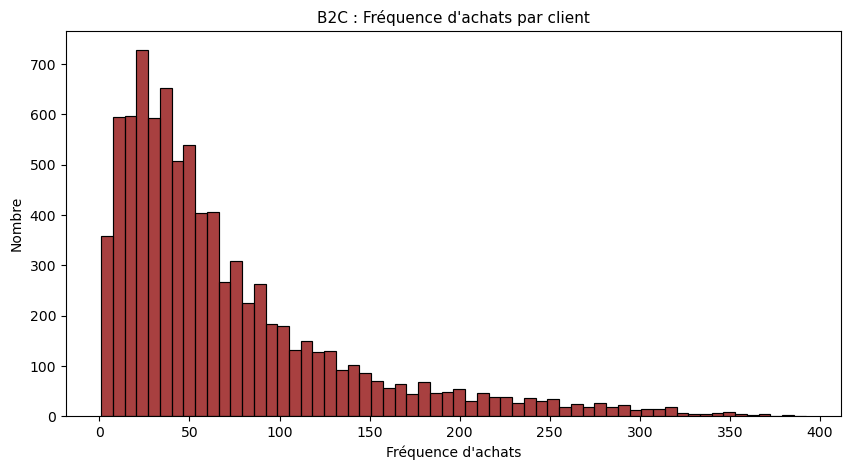

In [88]:
# Distribution fréquence d'achat
plt.figure(figsize=(10,5))
sns.histplot(data=df_client.loc[df_client.profil_client=='B2C'],x='freq_achat',color='darkred')
plt.xlabel("Fréquence d'achats")
plt.ylabel("Nombre")
plt.title("B2C : Fréquence d'achats par client",fontsize=11)
plt.show()

##### Panier moyen

In [89]:
df_client.sort_values('panier_moyen',ascending=False)

client_id sex   age  montant_total_achat classe_age groupe_age  \
1522    c_2369   f  24.0              1037.69       - 31       - 31   
7712    c_7941   m  19.0               482.32       - 31       - 31   
5448    c_5903   f  27.0              1154.41       - 31       - 31   
2412     c_317   f  25.0              1527.82       - 31       - 31   
7316    c_7585   m  29.0               732.29       - 31       - 31   
...        ...  ..   ...                  ...        ...        ...   
8498     c_890   f  21.0                24.32       - 31       - 31   
751     c_1675   f  23.0                33.42       - 31       - 31   
7905    c_8114   m  61.0                 9.98      52-61        52+   
4215    c_4794   m  37.0                32.93      32-41      32-51   
7934    c_8140   m  52.0                 8.30      52-61        52+   

      panier_moyen  taille_panier_moyen  freq_achat profil_client  
1522    259.422500                 1.75           7           B2C  
7712    241.160000                 2.00           4           B2C  
5448    230.882000                 3.80          19           B2C  
2412    190.977500                 4.75          38           B2C  
7316    183.072500                 2.00           8           B2C  
...            ...                  ...         ...           ...  
8498      6.080000                 1.00           4           B2C  
751       5.570000                 1.00           6           B2C  
7905      4.990000                 1.00           2           B2C  
4215      4.704286                 1.00           7           B2C  
7934      4.150000                 1.00           2           B2C  

[8598 rows x 10 columns]

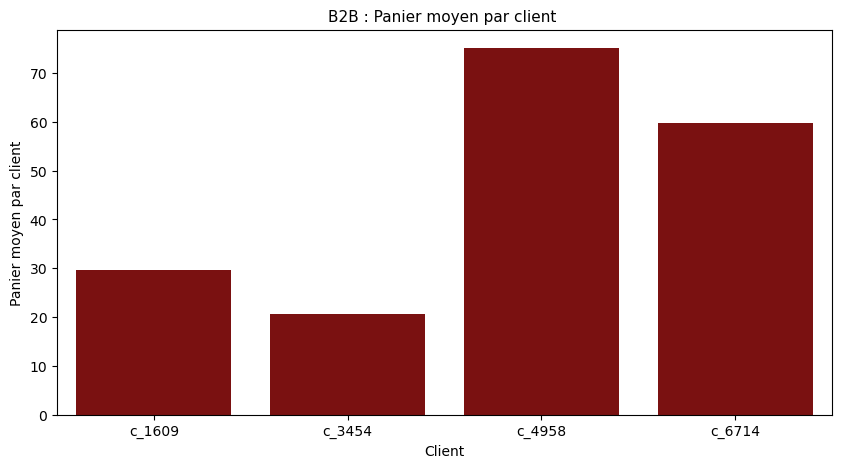

In [90]:
# Distrisbution du panier moyen par client B2B
plt.figure(figsize=(10,5))
sns.barplot(data=df_client.loc[df_client.profil_client=='B2B'],x='client_id',y='panier_moyen',color='darkred',)
plt.xlabel("Client")
plt.ylabel("Panier moyen par client")
plt.title("B2B : Panier moyen par client ",fontsize=11)
plt.show()


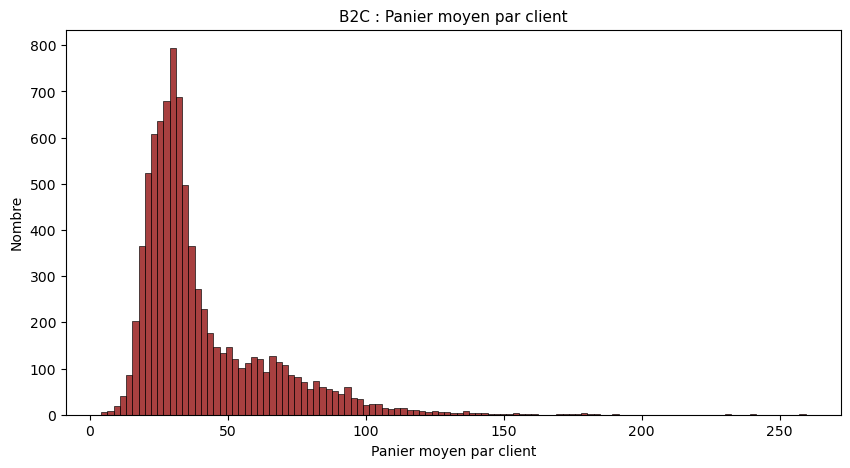

In [91]:
# Distribution du panier moyen par client
plt.figure(figsize=(10,5))
sns.histplot(data=df_client.loc[df_client.profil_client=='B2C'],x='panier_moyen',color='darkred')
plt.xlabel("Panier moyen par client")
plt.ylabel("Nombre")
plt.title("B2C : Panier moyen par client",fontsize=11)
plt.show()

##### Taille du panier moyen

In [92]:
df_client.sort_values('taille_panier_moyen',ascending=False)

client_id sex   age  montant_total_achat classe_age groupe_age  \
7919    c_8127   f  35.0               466.91      32-41      32-51   
2098    c_2888   f  19.0                96.49       - 31       - 31   
3976    c_4579   f  50.0               247.69      42-51      32-51   
2375    c_3136   f  39.0               176.13      32-41      32-51   
388     c_1348   f  26.0               562.84       - 31       - 31   
...        ...  ..   ...                  ...        ...        ...   
8347    c_8513   m  67.0               366.87      62-71        52+   
2815    c_3533   m  68.0               117.95      62-71        52+   
7461    c_7715   f  22.0               535.68       - 31       - 31   
5736    c_6162   m  63.0                68.67      62-71        52+   
7355     c_762   m  19.0               144.91       - 31       - 31   

      panier_moyen  taille_panier_moyen  freq_achat profil_client  
7919     93.382000                 8.20          41           B2C  
2098     96.490000                 7.00           7           B2C  
3976     61.922500                 6.25          25           B2C  
2375     88.065000                 6.00          12           B2C  
388      93.806667                 6.00          36           B2C  
...            ...                  ...         ...           ...  
8347     20.381667                 1.00          18           B2C  
2815      9.829167                 1.00          12           B2C  
7461     66.960000                 1.00           8           B2C  
5736     17.167500                 1.00           4           B2C  
7355     20.701429                 1.00           7           B2C  

[8598 rows x 10 columns]

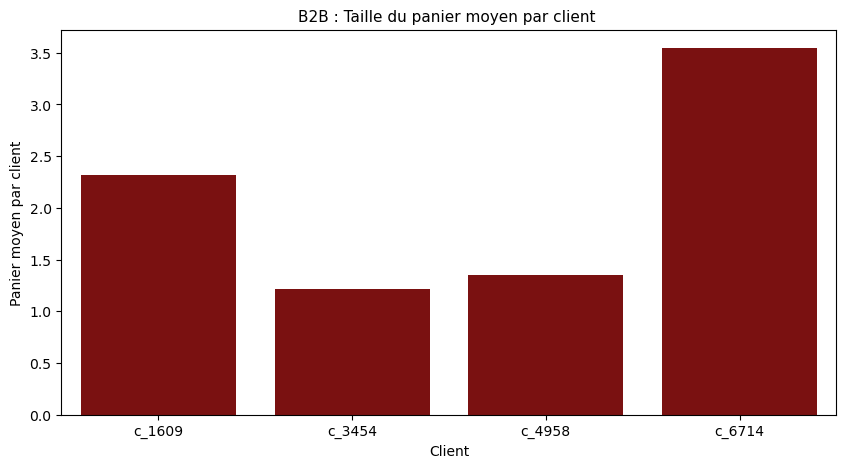

In [93]:
# Distrisbution de la taille du panier moyen par client B2B
plt.figure(figsize=(10,5))
sns.barplot(data=df_client.loc[df_client.profil_client=='B2B'],x='client_id',y='taille_panier_moyen',color='darkred',)
plt.xlabel("Client")
plt.ylabel("Panier moyen par client")
plt.title("B2B : Taille du panier moyen par client ",fontsize=11)
plt.show()


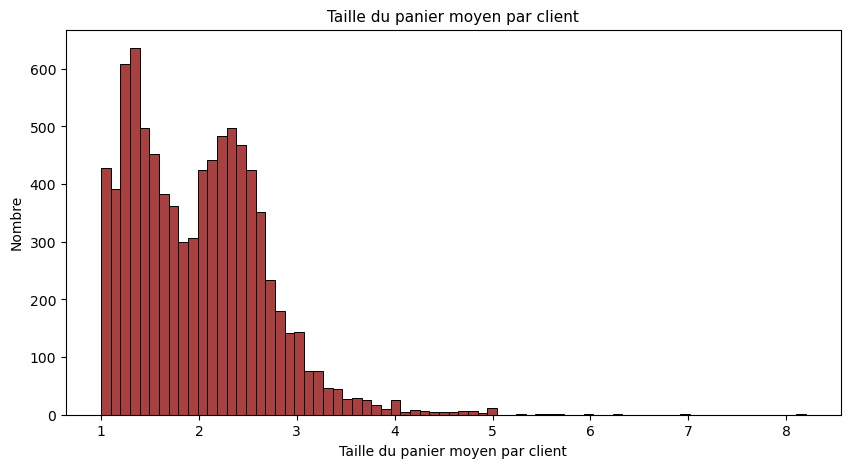

In [94]:
# Distribution de la taille du panier moyen par client
plt.figure(figsize=(10,5))
sns.histplot(data=df_client,x='taille_panier_moyen',color='darkred')
plt.xlabel("Taille du panier moyen par client")
plt.ylabel("Nombre")
plt.title("Taille du panier moyen par client",fontsize=11)
plt.show()

#### d. Chiffres d'affaires par profils client<a class="anchor" id="3_4_4">

##### Répartition chiffre d'affaires et volumes des ventes<a class="anchor" id="3_4_3_1"></a></font>

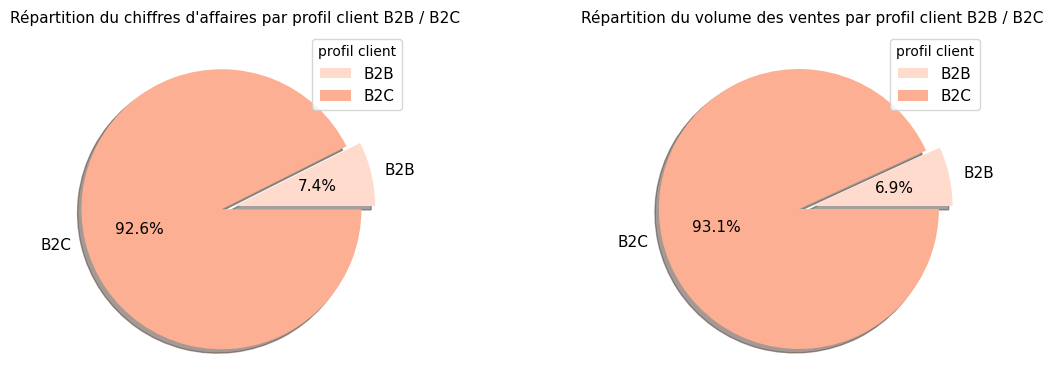

In [95]:
# création de la fenêtre graphique 1
plt.figure(1,figsize=(7,5))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

# division de la fenêtre graphique en 1 ligne, 2 colonnes,
# graphique en position 1
# puis caractéristiques de ce graphique
plt.subplot(1,2,1)
# Diagramme en secteurs pour représenter la répartition du CA par profil client
data = df_client.groupby('profil_client')['montant_total_achat'].sum().reset_index()
colors = sns.color_palette("Reds")
plt.pie(x=data['montant_total_achat'],labels=data['profil_client'],colors = colors,autopct='%.1f%%',explode =(0,0.1),
        textprops={'fontsize': 11}, shadow=True)

plt.title("Répartition du chiffres d'affaires par profil client B2B / B2C",fontsize=11)
plt.legend(title='profil client',
           fontsize=11,
           loc="upper right")

# graphique en position 2
# puis caractéristiques de ce graphique
plt.subplot(1,2,2)
# Diagramme en secteurs pour représenter la répartition des ventes par profil client
data = df_client.groupby('profil_client')['freq_achat'].sum().reset_index()
colors = sns.color_palette("Reds")
plt.pie(x=data['freq_achat'],labels=data['profil_client'],colors = colors,autopct='%.1f%%', explode =(0,0.1),
        textprops={'fontsize': 11}, shadow=True)

plt.title("Répartition du volume des ventes par profil client B2B / B2C",fontsize=11)
plt.legend(title='profil client', fontsize=11, loc="upper right")
plt.savefig('B2B-B2C.png')
plt.show()

Les clients B2B représentent 7,4% du chiffre d'affaires et 6,9% du volume des ventes.

Les clients B2C représentent 92,6% du chiffre d'affaires et 93,1% du volume des ventes.

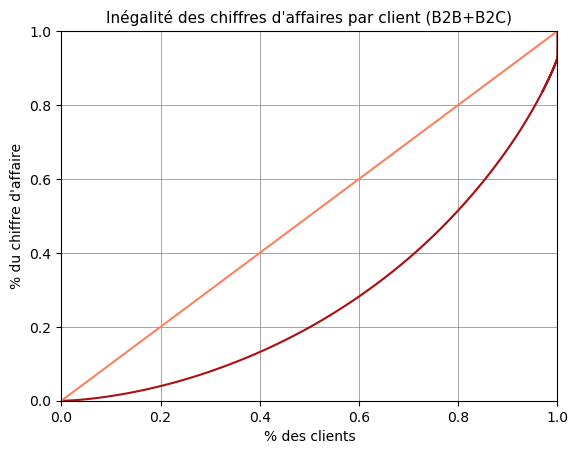

In [96]:
# Courbe de Lorenz
client = df_client['montant_total_achat'].values
n = len(client)
lorenz = np.cumsum(np.sort(client)) / client.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post',color='#aa1016')
plt.plot([0,1], [0,1],color='#fc8161') #tracer la bisséctrice
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("% des clients")
plt.ylabel("% du chiffre d'affaire")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.title("Inégalité des chiffres d'affaires par client (B2B+B2C)",fontsize=11)
plt.savefig('lorenz_b2b-b2c.png')
plt.show()

In [97]:
# Calcul de l'indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("Indice de Gini :",round(gini,2))

Indice de Gini : 0.45


Observations de la courbe de Lorenz : 
- 80% des clients représentent 50% du chiffre d'affaires.
- 10% des clients représentent 30% du chiffre d'affaires.

###### Clients Business to customer : B2C<a class="anchor" id="3_4_3_2"></a></font>

In [98]:
# Filtrage sur les clients particuliers (Business to customer = B2C)
df_client_B2C=df_client.loc[df_client['profil_client']=='B2C']

In [99]:
df_client_B2C['montant_total_achat'].describe(include='all')

count    8594.000000
mean     1242.504700
std       930.946938
min         8.300000
25%       533.967500
50%      1000.700000
75%      1729.252500
max      5214.050000
Name: montant_total_achat, dtype: float64

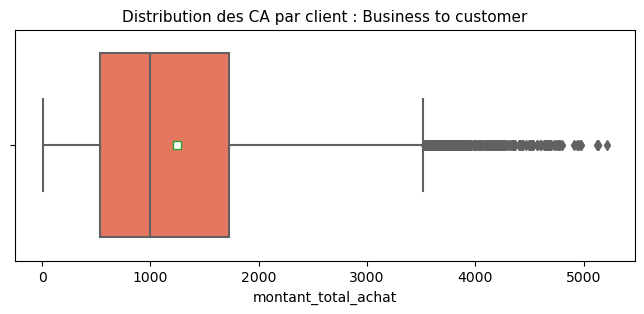

In [100]:
# Distribution et moyenne des CA par client
plt.figure(figsize=(8,3))
sns.boxplot(data=df_client_B2C, x='montant_total_achat', 
            orient='h', 
            showmeans=True, 
            palette="Reds", 
            meanprops={"marker":"s","markerfacecolor":"white"})
plt.title('Distribution des CA par client : Business to customer',fontsize=11)
plt.show()

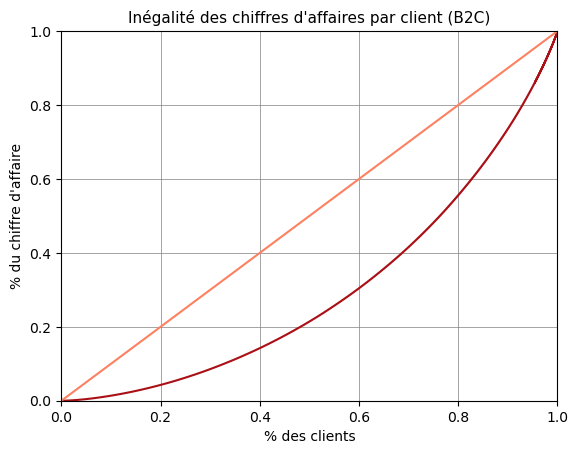

In [101]:
# Courbe de Lorenz
client = df_client_B2C['montant_total_achat'].values
n = len(client)
lorenz = np.cumsum(np.sort(client)) / client.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post',color='#aa1016')
plt.plot([0,1], [0,1],color='#fc8161') #tracer la bisséctrice
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("% des clients")
plt.ylabel("% du chiffre d'affaire")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.title("Inégalité des chiffres d'affaires par client (B2C)",fontsize=11)
plt.show()

In [102]:
# Calcul de l'indice de Gini
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("Indice de Gini :",round(gini,2))

Indice de Gini : 0.4


L'indice de Gini est plus faible si on ne considère que les clients B2C.

Observations :
- 10% des clients B2C réalisent 30% du chiffre d'affaires

### 5. Analyses complémentaires<a class="anchor" id="3_5"></a>

#### a. Chiffres clés par période d'activité<a class="anchor" id="3_5_1"></a>

In [103]:
# Définition des périodes d'activités sur une année glissante
df_final.loc[df_final['mois']<='2022-02','periode']=1
df_final.loc[df_final['mois']>'2022-02','periode']=2

##### Chiffres d'affaires

In [104]:
CA_=df_final.groupby('periode')['price'].sum().reset_index().rename(columns={'price':'CA_annuel'})
CA_

periode   CA_annuel
0      1.0  5832800.01
1      2.0  6023209.39

In [105]:
# Evolution période 1 - période 2
CA_1=CA_[CA_.periode==1.0].iloc[0,1]
CA_2=CA_[CA_.periode==2.0].iloc[0,1]
print("L'évolution du chiffre d'affaires annuel entre la période 1 et la période 2 est de"
      , round((CA_2-CA_1)/CA_1*100),"%.")

L'évolution du chiffre d'affaires annuel entre la période 1 et la période 2 est de 3 %.


In [106]:
# Chiffre d'affaires annuel moyen
print("Le chiffre d'affaires annuel moyen est de",round(CA_.CA_annuel.mean()),"euros")

Le chiffre d'affaires annuel moyen est de 5928005 euros


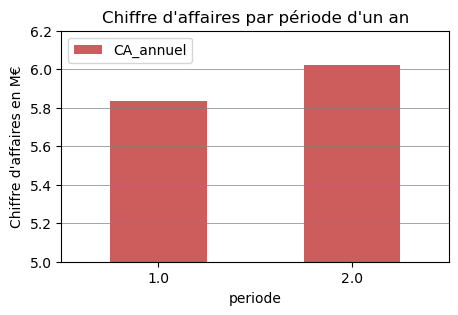

In [107]:
# Evolution période 1 - période 2
CA_.plot(x='periode',y='CA_annuel',kind='bar',figsize=(5,3),color='indianred')
plt.ylim(5e6,6.2e6)
plt.yticks([5.0e6,5.2e6,5.4e6,5.6e6,5.8e6,6.0e6,6.2e6],['5.0','5.2','5.4','5.6','5.8','6.0','6.2'])
plt.xticks(rotation=0)
plt.grid(axis='y',color='gray', linestyle='-', linewidth=0.5)
plt.title("Chiffre d'affaires par période d'un an")
plt.ylabel("Chiffre d'affaires en M€")
plt.legend(loc='upper left')
plt.show()

##### Nombre de ventes

In [108]:
print("Nombre de ventes sur les 2 années d'activités =",df_final_ok.loc[~df_final_ok.date.isna(),'date'].count())

Nombre de ventes sur les 2 années d'activités = 657726


In [109]:
# Définition des périodes d'activités sur une année glissante
df_final_ok.loc[df_final_ok['mois']<='2022-02','periode']=1
df_final_ok.loc[df_final_ok['mois']>'2022-02','periode']=2

C:\Users\Adeline\AppData\Local\Temp\ipykernel_17352\3853077837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_ok.loc[df_final_ok['mois']<='2022-02','periode']=1


In [110]:
ventes_=df_final_ok.groupby('periode')['date'].count().reset_index().rename(columns={'date':'Nb_ventes'})
ventes_

periode  Nb_ventes
0      1.0     315682
1      2.0     342044

In [111]:
# Evolution période 1 - période 2
ventes_1=ventes_[ventes_.periode==1.0].iloc[0,1]
ventes_2=ventes_[ventes_.periode==2.0].iloc[0,1]
print("L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de"
      , round((ventes_2-ventes_1)/ventes_1*100),"%.")

L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de 8 %.


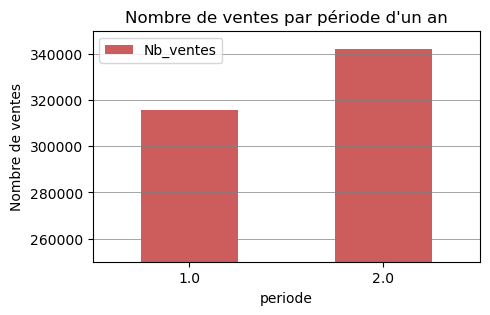

In [112]:
# Evolution période 1 - période 2
ventes_.plot(x='periode',y='Nb_ventes',kind='bar',figsize=(5,3),color='indianred')
plt.grid(axis='y',color='gray', linestyle='-', linewidth=0.5)
plt.ylim(250000,350000)
plt.ylabel("Nombre de ventes")
plt.xticks(rotation=0)
plt.title("Nombre de ventes par période d'un an")
plt.show()

##### Sessions d'achats

In [113]:
print("Nombre de sessions d'achats sur les 2 années d'activités =",
      df_final_ok.loc[~df_final_ok.date.isna(),'session_id'].unique().shape[0])

Nombre de sessions d'achats sur les 2 années d'activités = 330769


In [114]:
session_=df_final_ok.groupby(['periode','session_id'])['jour'].count().reset_index()
session_=session_.groupby('periode')['session_id'].count().reset_index().rename(columns={'session_id':'Nb_session'})
session_

periode  Nb_session
0      1.0      157648
1      2.0      173121

In [115]:
# Evolution période 1 - période 2
session_1=session_[session_.periode==1.0].iloc[0,1]
session_2=session_[session_.periode==2.0].iloc[0,1]
print("L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de"
      , round((session_2-session_1)/session_1*100),"%.")

L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de 10 %.


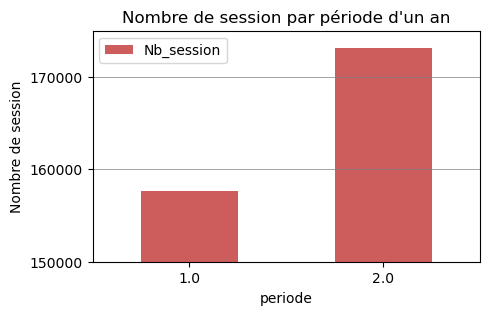

In [116]:
# Evolution période 1 - période 2
session_.plot(x='periode',y='Nb_session',kind='bar',figsize=(5,3),color='indianred')
plt.grid(axis='y',color='gray', linestyle='-', linewidth=0.5)
plt.ylim(150000,175000)
plt.yticks([150000,160000,170000],['150000','160000','170000'])
plt.ylabel("Nombre de session")
plt.xticks(rotation=0)
plt.title("Nombre de session par période d'un an")
plt.show()

##### Nombre de clients

In [117]:
print("Nombre de client ayant effectué des achats sur les 2 années d'activités =",
      df_final_ok.loc[~df_final_ok.date.isna(),'client_id'].unique().shape[0])

Nombre de client ayant effectué des achats sur les 2 années d'activités = 8598


In [118]:
client_=df_final_ok.groupby(['periode','client_id'])['jour'].count().reset_index()
client_=client_.groupby('periode')['client_id'].count().reset_index().rename(columns={'client_id':'Nb_client'})
client_

periode  Nb_client
0      1.0       8598
1      2.0       8524

In [119]:
# Evolution période 1 - période 2
client_1=client_[client_.periode==1.0].iloc[0,1]
client_2=client_[client_.periode==2.0].iloc[0,1]
print("L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de"
      , round((client_2-client_1)/client_1*100),"%.")

L'évolution du nombre de ventes annuel entre la période 1 et la période 2 est de -1 %.


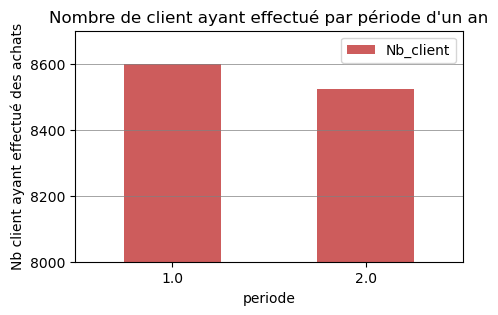

In [120]:
# Evolution période 1 - période 2
client_.plot(x='periode',y='Nb_client',kind='bar',figsize=(5,3),color='indianred')
plt.grid(axis='y',color='gray', linestyle='-', linewidth=0.5)
plt.ylim(8000,8700)
plt.yticks([8000,8200,8400,8600],['8000','8200','8400','8600'])
plt.xticks(rotation=0)
plt.title("Nombre de client ayant effectué par période d'un an")
plt.ylabel("Nb client ayant effectué des achats")
plt.show()

##### Fidélisation des clients

In [121]:
# Clients en période 1
client_1 = df_final_ok[df_final_ok.periode==1.0].groupby('client_id').sum().reset_index()

In [122]:
# Clients en période 2
client_2 = df_final_ok[df_final_ok.periode==2.0].groupby('client_id').sum().reset_index()

In [123]:
# Clients ayant effectué des achats qu'en période 1
print("Il y a ",client_1.loc[~client_1.client_id.isin(client_2.client_id),'client_id'].shape[0],"clients qui n'ont éffectué des achats qu'en période 1")

Il y a  74 clients qui n'ont éffectué des achats qu'en période 1


In [124]:
# Nouveau client en période 2
print("Il y a ",client_2.loc[~client_2.client_id.isin(client_1.client_id),'client_id'].shape[0],"nouveau client en période 2")

Il y a  0 nouveau client en période 2


In [125]:
# Taux de fidélisation des clients
nb_client_2 = client_2.shape[0]
nb_total_client = df_final_ok.loc[~df_final_ok.date.isna(),'client_id'].unique().shape[0]

print("Le taux de fidélisation des clients est de",round(nb_client_2 / nb_total_client*100),"%")

Le taux de fidélisation des clients est de 99 %


#### b.Informations sur les clients<a class="anchor" id="3_5_2"></a>

##### Genre des clients 

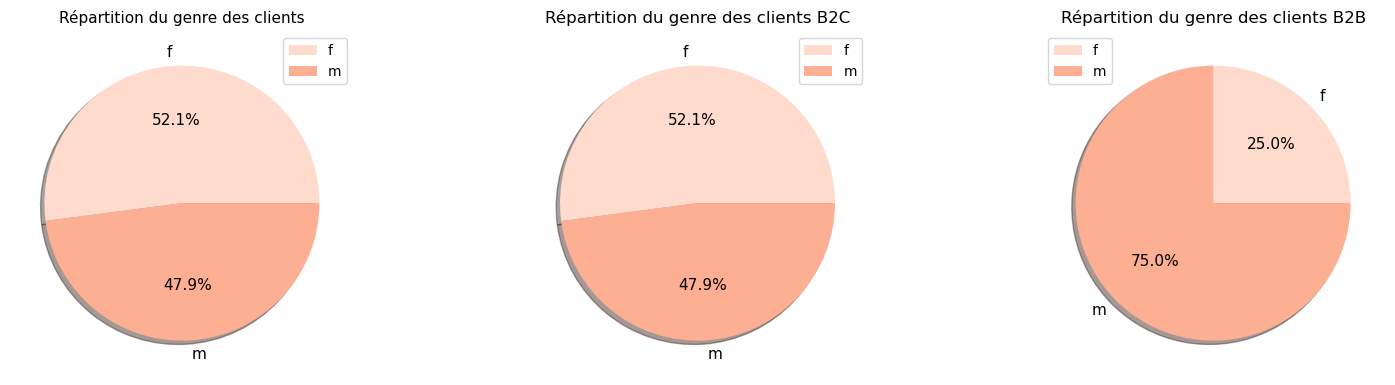

In [126]:
# création de la fenêtre graphique 1
plt.figure(1,figsize=(10,5))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

# division de la fenêtre graphique en 1 ligne, 3 colonnes,
# graphique en position 1
# puis caractéristiques de ce graphique
plt.subplot(1,3,1)
colors = sns.color_palette("Reds")
data = df_client.groupby('sex')['panier_moyen'].count().reset_index()
plt.pie(x=data['panier_moyen'],labels=data['sex'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        shadow=True)
plt.title("Répartition du genre des clients",fontsize=11)
plt.legend ()

# graphique en position 2
# puis caractéristiques de ce graphique
plt.subplot(1,3,2)
colors = sns.color_palette("Reds")
data = df_client.loc[df_client['profil_client']=='B2C',:].groupby('sex')['panier_moyen'].count().reset_index()
plt.pie(x=data['panier_moyen'],labels=data['sex'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11}, 
        shadow=True)
plt.title('Répartition du genre des clients B2C')
plt.legend()

# graphique en position 3
# puis caractéristiques de ce graphique
plt.subplot(1,3,3)
data = df_client.loc[df_client['profil_client']=='B2B',:].groupby('sex')['panier_moyen'].count().reset_index()
plt.pie(x=data['panier_moyen'],labels=data['sex'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11}, 
        shadow=True)
plt.title('Répartition du genre des clients B2B')
plt.legend()
plt.savefig('genre.png')
plt.show()

##### Pyramide des âges des clients

La pyramide des âges des clients nous montre une répartition équilibrée entre hommes et femmes.

In [127]:
# Création d'un tableau croisé 'age' - 'sex'
pyr_age=df_client.pivot_table(index='age',columns='sex',values='montant_total_achat',aggfunc=len).reset_index()
pyr_age.columns=['age','m','f']

In [128]:
# Création des variables x et y du graphe
y_age = pyr_age['age']
x_M = pyr_age['m']
x_F = pyr_age['f'] * -1 #multiplier par -1 pour affichage à l'opposé des données hommes

In [129]:
# Création de la fenêtre
fig = go.Figure()
  
# Ajout des données hommes sur le graphique
fig.add_trace(go.Bar(y= y_age, x = x_M, 
                     name = 'Homme', 
                     orientation = 'h'))
  
# Ajout des données femmes sur le graphique
fig.add_trace(go.Bar(y = y_age, x = x_F,
                     name = 'Femme', 
                     orientation = 'h'))
  
# Mise à jour du layout
fig.update_layout(title = 'Pyramide des âges des clients',
                 title_font_size = 20, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 yaxis = dict(title = 'Age',
                              title_font_size = 14),
                 xaxis = dict(tickvals = [-200, -150, -100, -50,
                                          0, 50, 100, 150,200],
                                
                              ticktext = ['200', '150', '100', '50', '0', 
                                          '50', '100', '150','200'],
                              title = 'Nombre de clients',
                              title_font_size = 14))
  
fig.show()

##### Classe d'âge

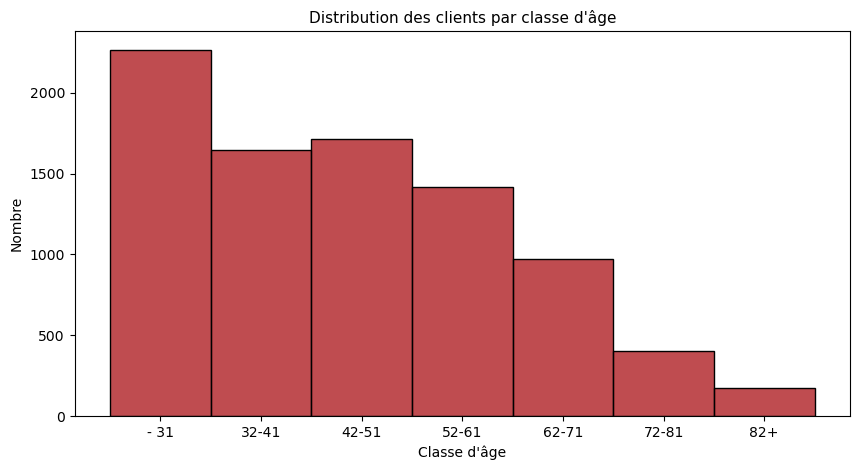

In [130]:
# Distribution de la taille du panier moyen par client
plt.figure(figsize=(10,5))
sns.histplot(data=df_client.sort_values('classe_age'),x='classe_age',color='#aa1016')
plt.xlabel("Classe d'âge")
plt.ylabel("Nombre")
plt.title("Distribution des clients par classe d'âge",fontsize=11)
plt.savefig('classe_age.png')
plt.show()

##### Groupe d'âge

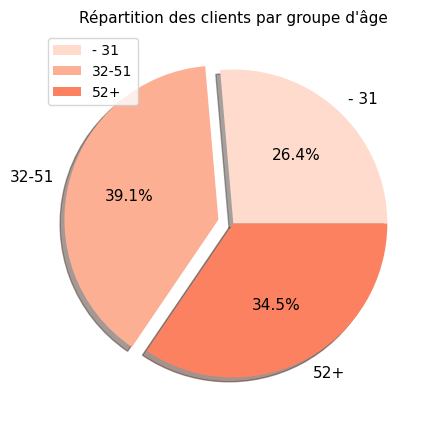

In [131]:
plt.figure(1,figsize=(10,5))
colors = sns.color_palette("Reds")
groupe_age = df_client.groupby('groupe_age')['client_id'].count().reset_index()
plt.pie(x=groupe_age['client_id'],labels=groupe_age['groupe_age'],colors = colors,
        autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0.1,0),shadow=True)
plt.title("Répartition des clients par groupe d'âge",fontsize=11)
plt.legend(loc='upper left')
plt.show()

##### Nombre de clients achetant dans chaque catégorie

In [132]:
df_cat = df_final_ok.groupby(['categ','client_id'])['date'].count().reset_index()
df_cat = df_cat.groupby('categ')['client_id'].count().reset_index().rename(columns={'client_id':'Nb_client'})

# Nombre de clients ayant effectué un acInfohat
nb_client = df_final_ok.loc[~df_final_ok.date.isna()].groupby('client_id').sum().shape[0]
df_cat['%_client'] = round(df_cat['Nb_client'] / nb_client * 100,1)

df_cat

categ  Nb_client  %_client
0    0.0       7828      91.0
1    1.0       8446      98.2
2    2.0       3515      40.9

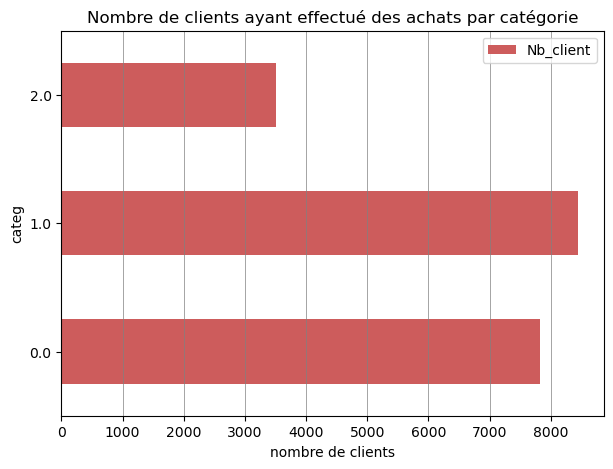

In [133]:
# Graphique bar plot pour représenter le nombre de clients achetant dans chaque catégorie
df_cat.plot( x = 'categ', y = 'Nb_client', kind = 'barh', color='indianred',figsize=(7,5))
plt.xlabel('nombre de clients')
plt.grid(axis='x',color='gray', linestyle='-', linewidth=0.5)
plt.title('Nombre de clients ayant effectué des achats par catégorie')
plt.show()

#### c. Habitudes d'achats des profils clients<a class="anchor" id="3_5_3"></a>

Pour analyser les habitudes d'achats des profils clients, il est nécessaire de rassembler dans un même data frame les informations des habitudes clients, df_client et des transactions, df_final_ok.

##### Data frame global

In [134]:
# Sélection des colonnes classe_age et profil_client
df=df_client[['classe_age','groupe_age','profil_client','client_id']]

#Jointure du df_client et du df_final_ok
df_global=pd.merge(df_final_ok,df,on='client_id',how='outer',indicator=True)
df_global.shape

(657770, 17)

In [135]:
df_global.head(5)

id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   
2  0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   f   
3  0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   f   
4  0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   f   

    birth   age année     mois        jour  periode classe_age groupe_age  \
0  1986.0  37.0  2022  2022-05  2022-05-20      2.0      32-41      32-51   
1  1986.0  37.0  2021  2021-07  2021-07-20      1.0      32-41      32-51   
2  1986.0  37.0  2022  2022-08  2022-08-20      2.0      32-41      32-51   
3  1986.0  37.0  2022  2022-06  2022-06-18      2.0      32-41      32-51   
4  1986.0  37.0  2021  2021-08  2021-08-18      1.0      32-41      32-51   

  profil_client _merge  
0           B2C   both  
1           B2C   both  
2           B2C   both  
3           B2C   both  
4           B2C   both

In [136]:
#Filtrage sur les valeurs de la colonne '_merge' qui sont différentes de 'both'
print("Il y a ",df_global.loc[df_global['_merge']!='both',:].shape[0]," lignes qui ne sont pas dans les 2 df.")

Il y a  44  lignes qui ne sont pas dans les 2 df.


Il s'agit des 21 produits qui n'ont pas été vendus en ligne et des 23 clients qui n'ont pas réalisé d'achat en ligne.

In [137]:
# Suppression de la colonne _merge
df_global.pop('_merge')

# Suppression des livres non vendus et des clients n'ayant effectué aucun achat
df_global=df_global.loc[~(df_global['date']).isna()]

##### Clients B2B

In [138]:
df_client.loc[df_client.profil_client=='B2B']

client_id sex   age  montant_total_achat classe_age groupe_age  \
678     c_1609   m  43.0            312755.08      42-51      32-51   
2727    c_3454   m  54.0            111797.67      52-61        52+   
4397    c_4958   m  24.0            282654.61       - 31       - 31   
6349    c_6714   f  55.0            149845.67      52-61        52+   

      panier_moyen  taille_panier_moyen  freq_achat profil_client  
678      29.678789             2.322262       24472           B2B  
2727     20.535942             1.218773        6635           B2B  
4397     75.094211             1.352285        5090           B2B  
6349     59.675695             3.545599        8903           B2B

In [139]:
# Filtrage sur les clients B2B
df_B2B=df_global[df_global.profil_client=='B2B']

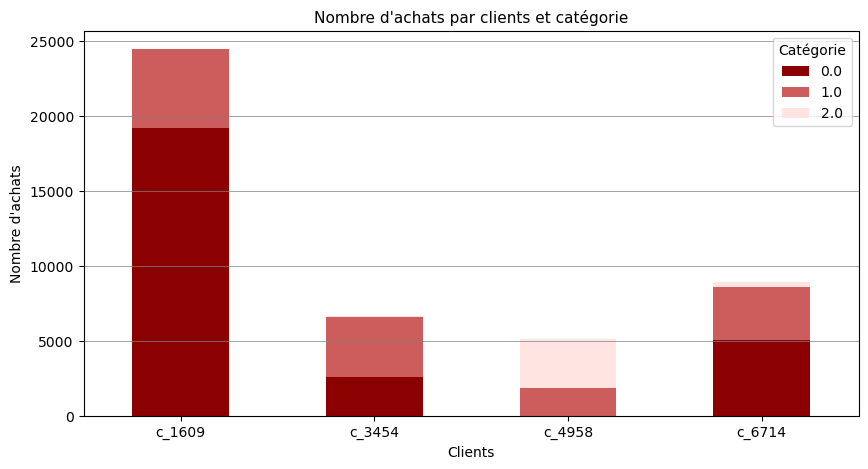

In [140]:
# Réprésentation du volume d'achat par client et catégorie, diagramme à barres empilées
df_B2B.pivot_table(index='client_id', columns='categ',values='date', aggfunc='count')\
         .plot.bar(stacked=True,color=['darkred', 'indianred','mistyrose'],rot=0, figsize=(10,5))
plt.xlabel("Clients")
plt.ylabel("Nombre d'achats")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie',loc='upper right')
plt.title("Nombre d'achats par clients et catégorie",fontsize=11)
plt.show()

In [141]:
# Achats par catégorie et par client : chiffres
df_B2B.groupby(['client_id','categ'])['id_prod'].count().reset_index()

client_id  categ  id_prod
0     c_1609    0.0    19184
1     c_1609    1.0     5277
2     c_1609    2.0       11
3     c_3454    0.0     2584
4     c_3454    1.0     4035
5     c_3454    2.0       16
6     c_4958    0.0        1
7     c_4958    1.0     1877
8     c_4958    2.0     3212
9     c_6714    0.0     5073
10    c_6714    1.0     3537
11    c_6714    2.0      293

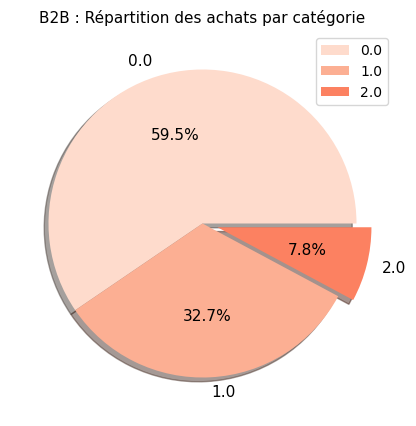

In [142]:
# Répartition des achats par catégorie
plt.figure(1,figsize=(10,5))
colors = sns.color_palette("Reds")
categ_B2B = df_B2B.groupby('categ')['id_prod'].count().reset_index()
plt.pie(x=categ_B2B['id_prod'],labels=categ_B2B['categ'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0,0.1),shadow=True)
plt.title("B2B : Répartition des achats par catégorie",fontsize=11)
plt.legend()
plt.show()

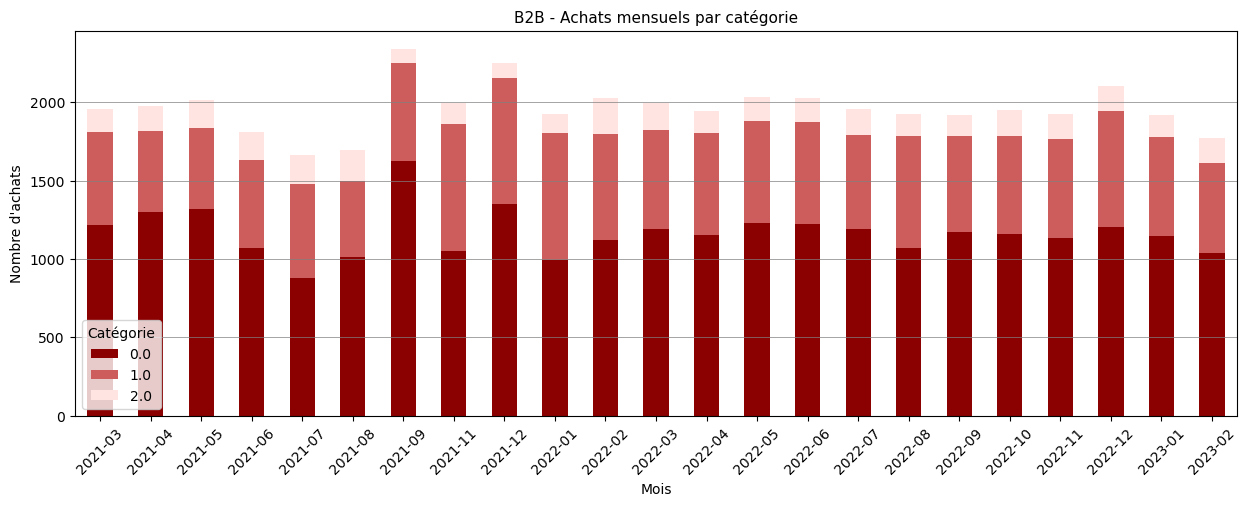

In [143]:
#Volume d'achats par mois pour les B2B
df_B2B.pivot_table(index='mois', columns='categ',values='date', aggfunc='count')\
    .plot.bar(stacked=True,color=['darkred', 'indianred','mistyrose'],rot=45, figsize=(15,5))
plt.xlabel("Mois")
plt.ylabel("Nombre d'achats")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie',loc='lower left')
plt.title("B2B - Achats mensuels par catégorie",fontsize=11)
plt.show()

Clients B2B - Ventes mensuelles par catégorie


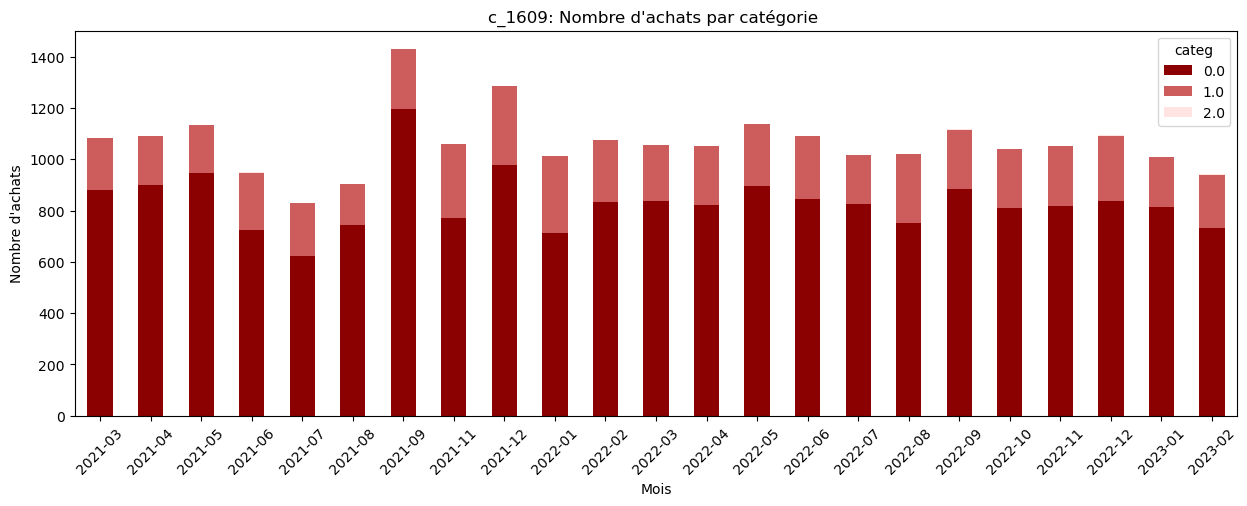

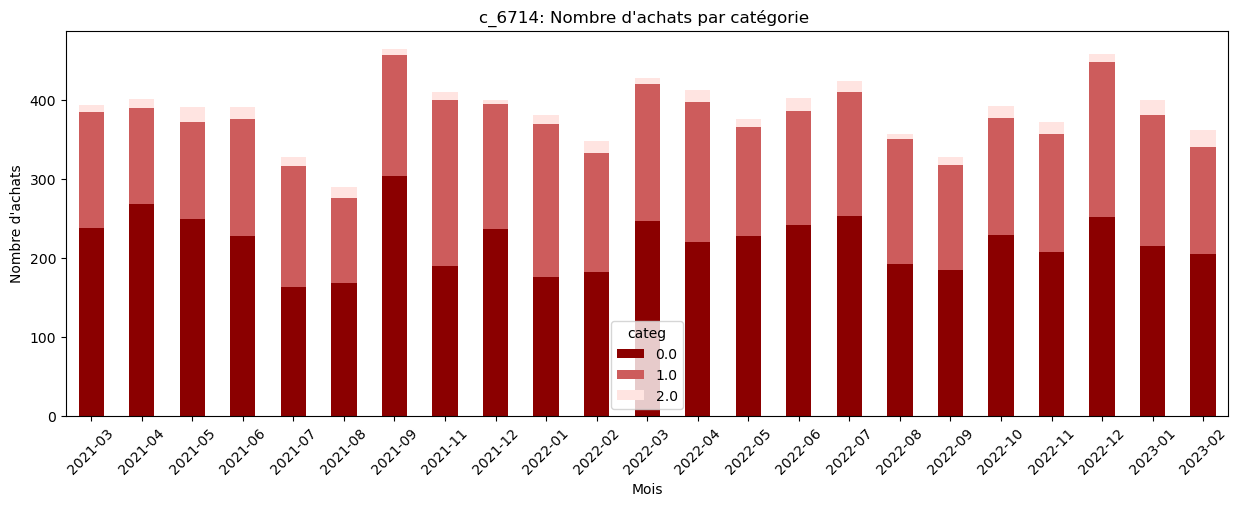

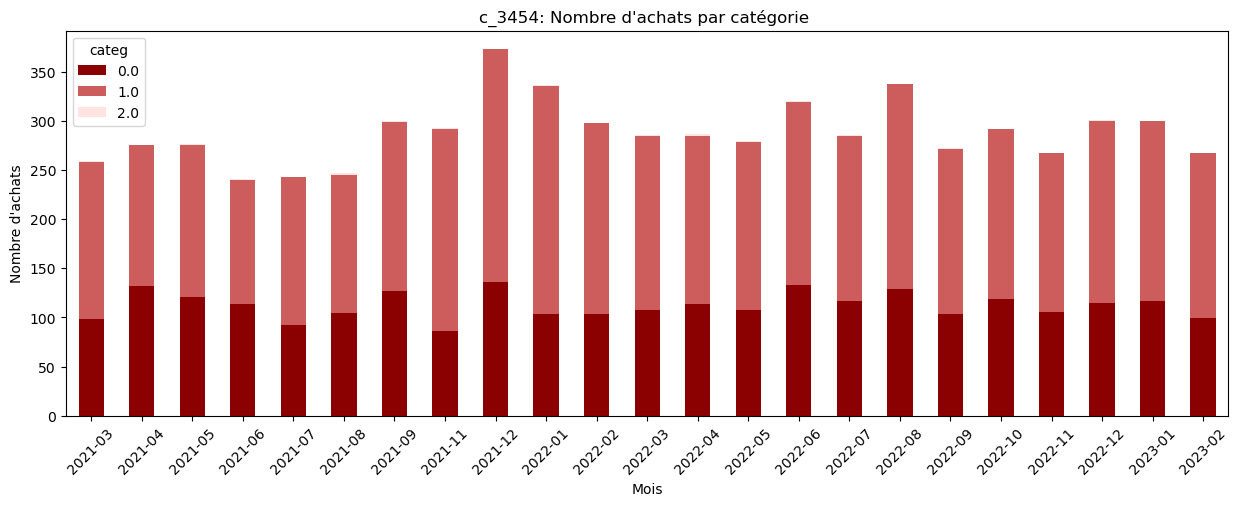

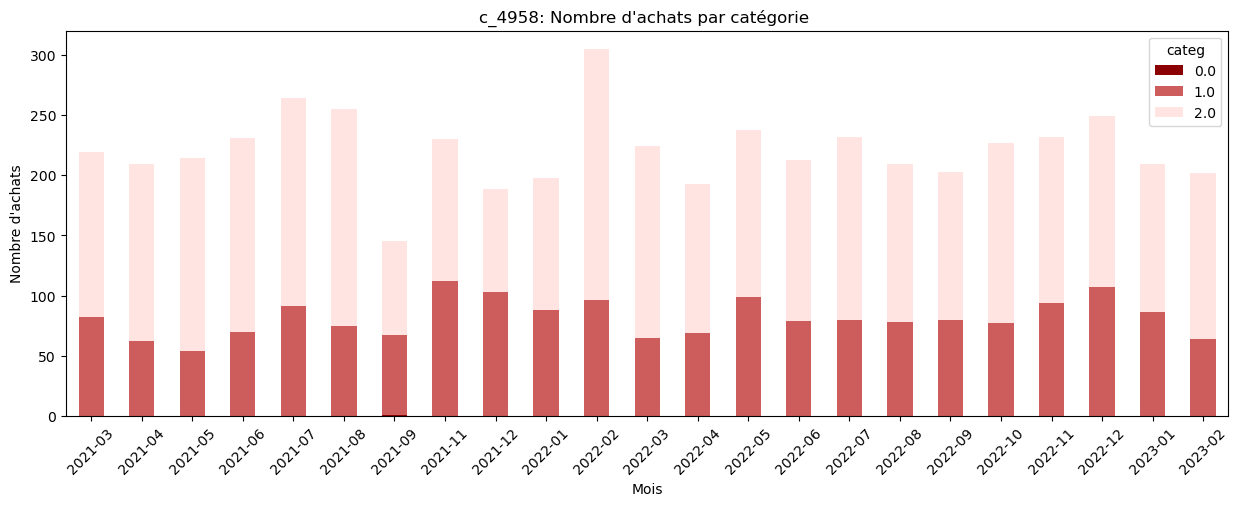

In [144]:
# Observations des indicateurs statistiques et graphiques pour chaque catégorie
print("Clients B2B - Ventes mensuelles par catégorie")

for client in df_B2B.client_id.unique():
    df_B2B[df_B2B.client_id==client].pivot_table(index='mois', columns='categ',values='date', aggfunc='count')\
    .plot.bar(stacked=True,color=['darkred', 'indianred','mistyrose'],rot=45, figsize=(15,5))
    plt.xlabel('Mois')
    plt.ylabel("Nombre d'achats")
    plt.title(str(client)+": Nombre d'achats par catégorie ")
    plt.show()

##### Clients B2C

In [145]:
# Filtrage sur les clients B2C ayant effectués des achats
df_B2C=df_global.loc[df_global['profil_client']=='B2C']

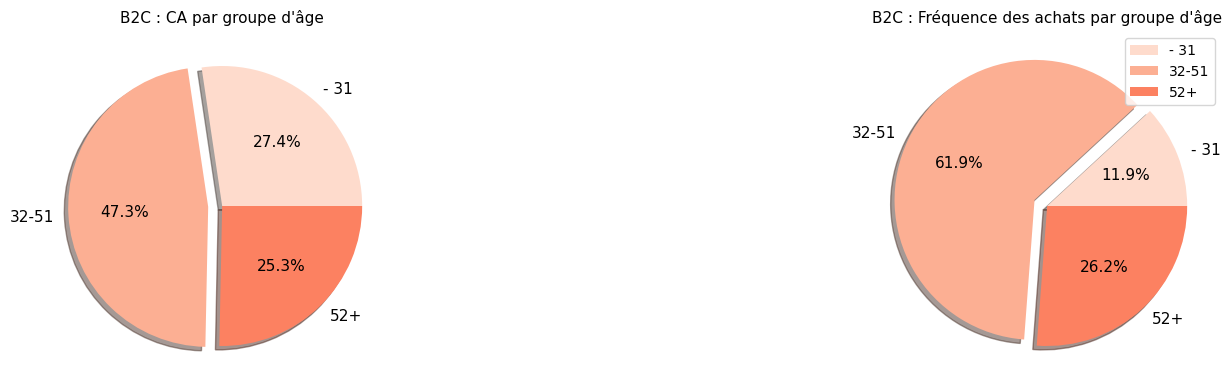

In [146]:
# création de la fenêtre graphique 1
plt.figure(1,figsize=(10,5))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

# division de la fenêtre graphique en 1 ligne, 3 colonnes,

# graphique en position 1 : Répartition du montant des achats par groupe d'âge
plt.subplot(1,2,1)
colors = sns.color_palette("Reds")
CA_B2C = df_B2C.groupby('groupe_age')['price'].sum().reset_index()
plt.pie(x=CA_B2C['price'],labels=CA_B2C['groupe_age'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0.1,0),shadow=True)
plt.title("B2C : CA par groupe d'âge",fontsize=11)

# graphique en position 2 : Répartition de la fréquence des achats par groupe d'âge
plt.subplot(1,2,2)
colors = sns.color_palette("Reds")
CA_B2C = df_B2C.groupby('groupe_age')['price'].count().reset_index()
plt.pie(x=CA_B2C['price'],labels=CA_B2C['groupe_age'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0.1,0),shadow=True)
plt.title("B2C : Fréquence des achats par groupe d'âge",fontsize=11)
plt.legend()

plt.show()

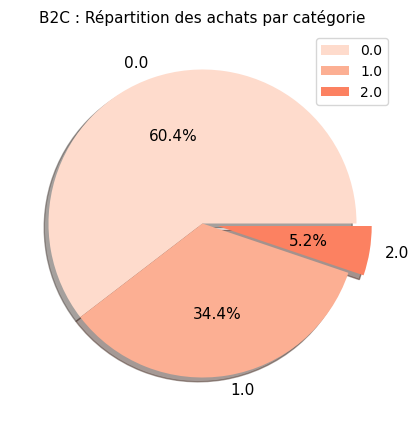

In [147]:
# Répartition des achats par catégorie
plt.figure(1,figsize=(10,5))
colors = sns.color_palette("Reds")
categ_B2C = df_B2C.groupby('categ')['id_prod'].count().reset_index()
plt.pie(x=categ_B2C['id_prod'],labels=categ_B2C['categ'],colors = colors,autopct='%.1f%%',textprops={'fontsize': 11},
        explode=(0,0,0.1),shadow=True)
plt.title("B2C : Répartition des achats par catégorie",fontsize=11)
plt.legend()
plt.show()

- Les clients de 30 à 50 ans achètent majoritairement des livres de catégorie 0.
- Les clients de moins de 30 ans achètent le plus de catégorie 2.
- La catégorie 1 est achetée par tous les âges et principalement par les 30-70 ans.

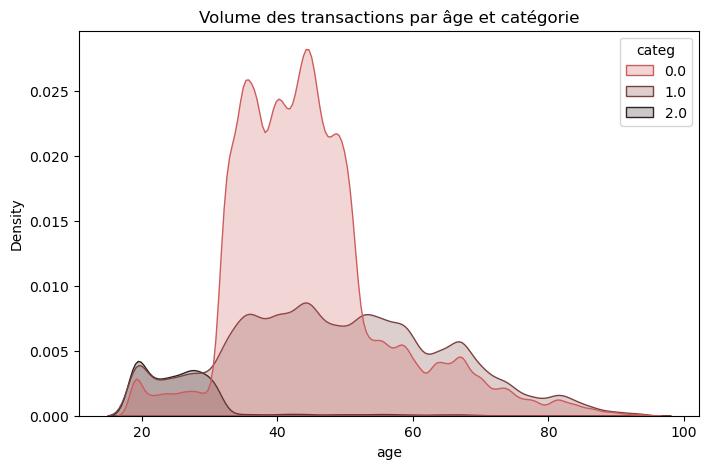

In [148]:
# Volumes des transactions par age et par catégorie
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_B2C, x='age', hue='categ', fill=True, palette="dark:indianred_r")
plt.title('Volume des transactions par âge et catégorie')
plt.savefig('b2c_ventes_age-categ.png')
plt.show()

Nous n'observons pas de périodicité dans les achats. Une plus grande période d'activité est nécessaire car l'année 2021 a pu être influencée par les restrictions liées au Covid.

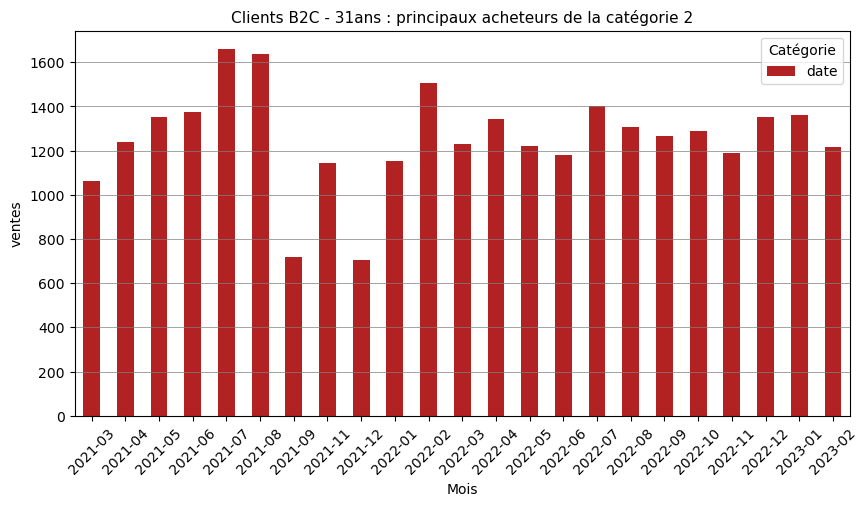

In [149]:
#Volume des ventes par mois pour les moins de 31 
df_B2C[(df_B2C['classe_age']=='- 31')&(df_B2C['categ']==2.0)].groupby('mois')['date'].count()\
         .plot.bar(color=['firebrick'],rot=45, figsize=(10,5))
plt.xlabel("Mois")
plt.ylabel("ventes")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Clients B2C - 31ans : principaux acheteurs de la catégorie 2",fontsize=11)
plt.show()

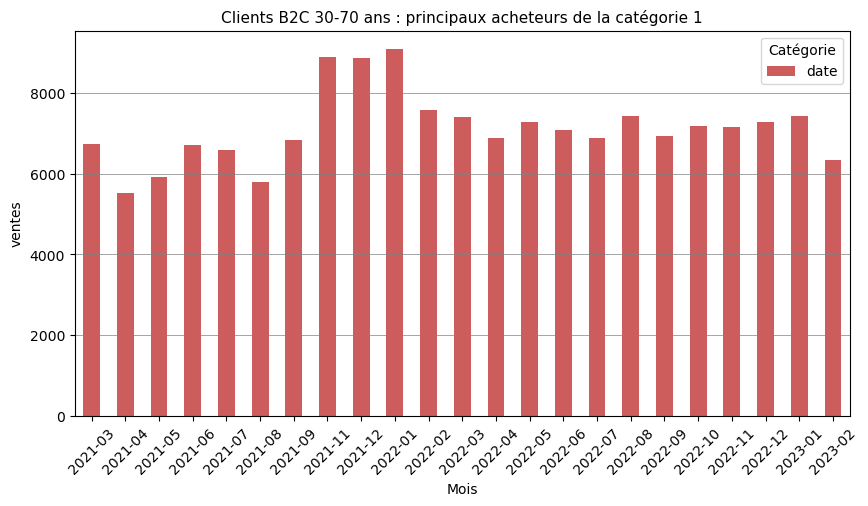

In [150]:
#Volume des ventes par mois pour les 30-70
df_B2C[(df_B2C['age']>=32)&(df_B2C['age']<=70)&(df_B2C['categ']==1.0)].groupby('mois')['date'].count()\
         .plot.bar(color=['indianred'],rot=45, figsize=(10,5))
plt.xlabel("Mois")
plt.ylabel("ventes")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Clients B2C 30-70 ans : principaux acheteurs de la catégorie 1",fontsize=11)
plt.show()

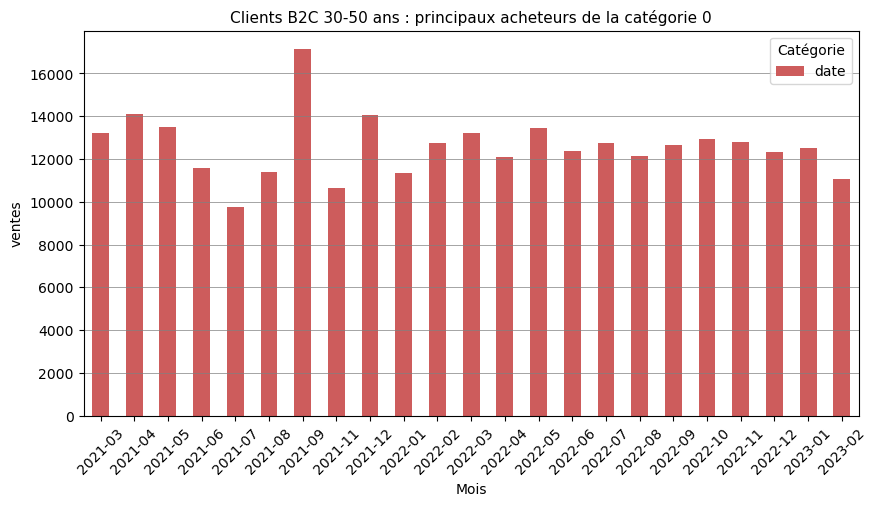

In [151]:
#Volume des ventes par mois pour les 30-50
df_B2C[(df_B2C['age']>=32)&(df_B2C['age']<=52)&(df_B2C['categ']==0.0)].groupby('mois')['date'].count()\
         .plot.bar(color=['indianred'],rot=45, figsize=(10,5))
plt.xlabel("Mois")
plt.ylabel("ventes")
plt.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
plt.legend(title='Catégorie')
plt.title("Clients B2C 30-50 ans : principaux acheteurs de la catégorie 0",fontsize=11)
plt.show()

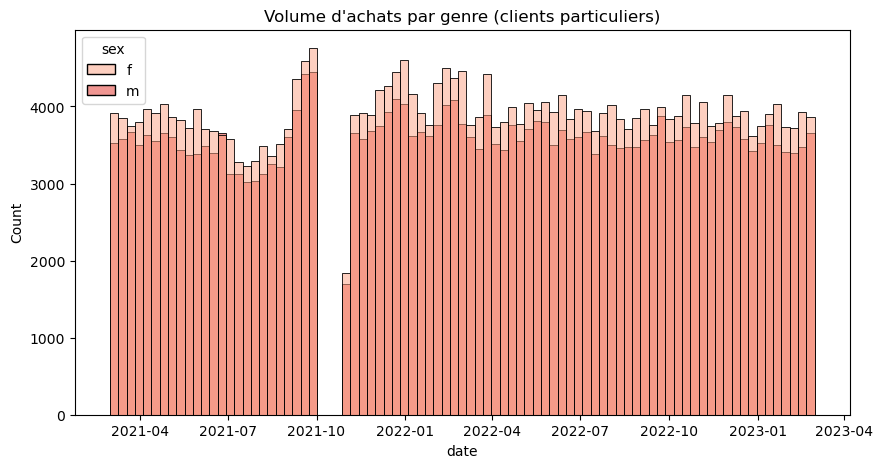

In [152]:
# Volume des ventes par genre
plt.figure(figsize=(10,5))
sns.histplot(data=df_B2C, x='date', hue='sex', palette='Reds')
plt.title("Volume d'achats par genre (clients particuliers)")
plt.savefig('ventes_genre.png')
plt.show()

In [153]:
# Enregistrement du dataframe df_global et df_client en .csv pour la partie 4
df_client.to_csv("df_client.csv")
df_global.to_csv("df_global.csv")